In [1]:
from HeaderP import *
from scipy.interpolate import interp1d

In [2]:
def log_prior(params):
    m = params[0]
    return -1.5 * np.log(1 + m*m)

def log_marg_prob_scatter(params, S, yn, xn):
    m, b, log_lambda = params
    v = np.array([-m, 1.0])

    # Enforce the log-uniform prior on lambda. 
    if not -5.0 < log_lambda < 5.0:
        return -np.inf

    # Compute \Sigma^2 and \Delta.
    lamd = np.exp(log_lambda)
    Lambda = np.zeros((2,2))
    Lambda[0,0], Lambda[0,1], Lambda[1,0], Lambda[1,1] =  m**2, -m, -m, 1
    Lambda = Lambda * lamd**2/(1+m**2)
    Sigma2 = np.dot(np.dot(S+Lambda, v), v)
    Delta = m * xn + b - yn

    # Compute the log likelihood up to a constant.
    ll = -0.5 * np.sum(Delta**2 / Sigma2 + np.log(Sigma2))
    return ll + log_prior(params)

import emcee

def monoage(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5]):
    colors = getcolor(range(len(agebin)+1))
    plt.figure(figsize=(20,8))
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        r_sing = r_sing[m2]
        feh_sing = feh_sing[m2]
        
        r_ave, feh_ave = movingMed_time(r_sing, feh_sing, 1, 0.1)
        #feh_ave = gaussian_filter(feh_ave, 4)
        """if agebin[i]==12.:
            plt.plot(r_sing, feh_sing,'.', color=colors[i], markersize=1)"""
        plt.plot(r_ave, feh_ave, color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
    plt.grid(color='grey', linestyle='-', linewidth=1)
    plt.xlabel('R [kpc]')
    plt.ylabel('[Fe/H]')
    plt.xlim(xlims)
    plt.ylim(ylims)

def getscatt_bay(feh, r, age, feh_err, r_err, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    
    nwalkers=64
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    scatters_err = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    feherr = feh_err[m]
    rerr = r_err[m]
    
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        feh_err_sing = feherr[m]
        r_err_sing = rerr[m]
        
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                #print(agebin[i], rbins[j], sum(m))
                print('not enough stars')
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                feh_err_sing_2 = feh_err_sing[m]
                r_err_sing_2 = r_err_sing[m]
        
                S = np.zeros((len(feh_sing_2),2,2))
                for k in range(len(feh_sing_2)):
                    S[k,0,0] = r_err_sing_2[k]**2
                    S[k,1,1] = feh_err_sing_2[k]**2
                print(agebin[i], rbins[j], len(feh_sing_2))
                z = np.polyfit(r_err_sing_2,feh_sing_2,1)
                sampler_scatter = emcee.EnsembleSampler(nwalkers, 3, log_marg_prob_scatter, args=(S, feh_sing_2, r_sing_2))
                p0 = np.array([z[0], z[1], np.log(0.03)])
                p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))
                pos, _, _ = sampler_scatter.run_mcmc(p0, 1000, progress=True)
                sampler_scatter.reset()
                sampler_scatter.run_mcmc(pos, 6000, progress=True)
                samples_scatter = sampler_scatter.flatchain

                """# m
                mcmc = np.percentile(samples_scatter[:, 0], [16, 50, 84])
                q = np.diff(mcmc)
                hi_m[i,0], hi_m[i,1], hi_m[i,2] = mcmc[1], q[0], q[1]

                # b
                mcmc = np.percentile(samples_scatter[:, 1], [16, 50, 84])
                q = np.diff(mcmc)
                hi_b[i,0], hi_b[i,1], hi_b[i,2] = mcmc[1], q[0], q[1]"""

                # dispersion
                mcmc = np.percentile(samples_scatter[:, 2], [16, 50, 84])
                q = np.diff(mcmc)
                scatters[i,j], dishi, dislow = mcmc[1], q[0], q[1]
                scatters_err[i,j] = np.mean(abs(dishi)+abs(dislow))

                
    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters, scatters_err


def getscatt(feh, r, age, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    if len(feherr)>0:
            feherr = feherr[m]
    
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        if len(feherr)>0:
            feh_err_sing = feherr[m]
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                #print('not enough stars')
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                p = fitpoints(r_sing_2, feh_sing_2) 
                scatters[i,j] = np.std(feh_sing_2-p(r_sing_2))

                if len(feherr)>0:
                    feh_err_sing_2 = feh_err_sing[m]
                    scatters[i,j] = np.sqrt(scatters[i,j]**2-np.mean(feh_err_sing_2)**2)
                    #print(scatters[i,j])
    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters
    
def monoage_line(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],
                feherr=[], plotlegend=True, pltfig=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    if pltfig:
        plt.figure(figsize=(20,8))
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            slopes[i] = np.nan
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            slopes[i] = np.nan
            fehscatter[i] = np.nan
            continue
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        fehscatter[i] = np.std(feh_sing[m2]-p(r_sing[m2]))
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        if pltfig:
            plt.plot(r_sing[m2], p(r_sing[m2]), color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    if pltfig:
        if plotlegend:
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
        plt.xlabel('R [kpc]')
        plt.ylabel('[Fe/H]')
        plt.xlim(xlims)
        plt.ylim(ylims)
    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter
    
def getcolor(vrange, cmap=plt.cm.get_cmap('plasma')):
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    #print([cmap(norm(i)) for i in vrange])
    return [cmap(norm(i)) for i in vrange]


def avr(age, r, vz, rbin=np.linspace(6,12,4), agebin=np.linspace(0,14,10)):
    colors = getcolor(range(len(rbin)+1))
    avrs = np.zeros((len(rbin)-1, len(agebin)-1))
    for i in range(len(rbin)-1):
        m = (r>rbin[i])&(r<rbin[i+1])
        age_r, r_r, vz_r = age[m], r[m], vz[m]
        for j in range(len(agebin)-1):
            m2 = (age_r>agebin[j])&(age_r<agebin[j+1])
            if sum(m2)<50:
                avrs[i,j]=np.nan
            else:
                vz_r_age = vz_r[m2]
                avrs[i,j] = 1.5*sum(abs(vz_r_age-np.median(vz_r_age)))/sum(m2)
    return (agebin[:-1]+agebin[1:])/2, (rbin[:-1]+rbin[1:])/2, avrs
  

# Maosheng subgiant: https://www.nature.com/articles/s41586-022-04496-5

In [161]:
from astropy.table import Table
sub = Table.read('subgiant_fullparam_update.fits', format='fits')
sub = sub.to_pandas()
sub_rbir = pd.read_csv('RbirLAMOST.csv')
sub_rbir.columns

sub_rbir = sub_rbir.rename(columns={'          rb': 'Rb', 
                                    '          rb_err': 'Rb_err',
                                   '       specid':'specid'})
sub['SPECID'] = [str(i.decode(encoding="utf-8").split()[0]) for i in sub['SPECID']]
sub_rbir['specid'] = [str(i.split()[0]) for i in sub_rbir['specid']]

sub_rbir = pd.merge(sub, 
               sub_rbir[['specid', 'Rb', 'Rb_err']], 
               left_on='SPECID', right_on='specid', how='inner')
print(len(sub_rbir), len(sub))

200674 247104


<AxesSubplot:>

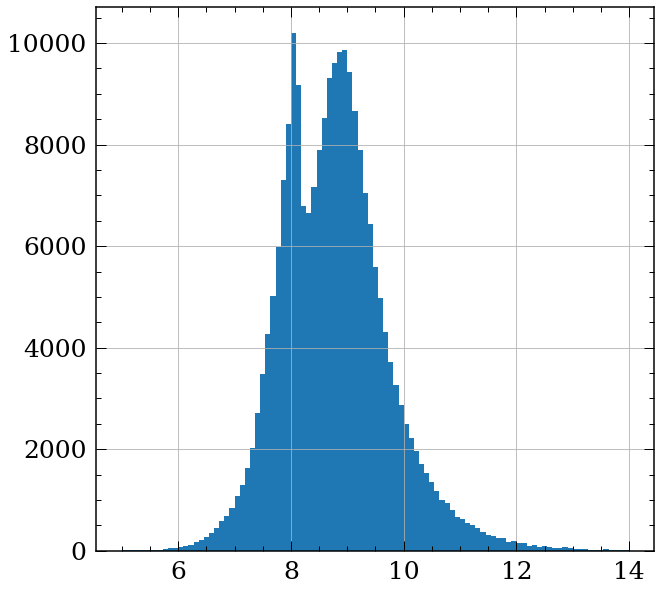

In [175]:
sub['R'].hist(bins=np.linspace(5,14,100))

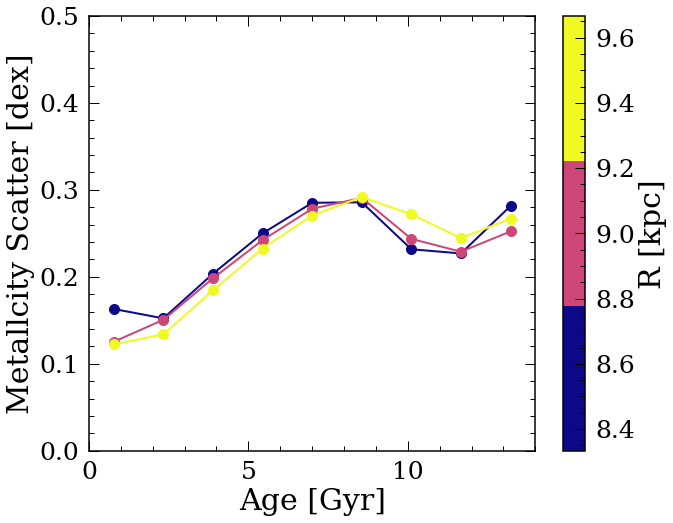

In [178]:
# scattering at different radius
m = (abs(sub['Z'])<1)
ages, rs, scatters = getscatt(sub['FEH'].values[m], 
                                        sub['R'].values[m], 
                                        sub['AGE'].values[m],
                                        agebin=np.linspace(0,14,10),
                                        xlims=[8,10],rbin=4,
                                       feherr=sub['FEH_ERR'].values[m])


colors = getcolor(rs)
plt.figure(figsize=(10,8))
for i in range(len(rs)):
    plt.plot(ages, scatters[:,i], '-o', color=colors[i], markersize=10)
plt.scatter(-10,-10,c=0, vmin=min(rs), vmax=max(rs),
            cmap=plt.get_cmap('plasma', len(rs)))
cb = plt.colorbar()
cb.set_label('R [kpc]')
plt.xlabel('Age [Gyr]')
plt.ylabel('Metallcity Scatter [dex]')
plt.xlim([0,14])
plt.ylim([0,0.5])
plt.show()




Before eccentricity cut:
227909 197211
After eccentricity cut:
227909 197211
2075.0 2903.7226728396913
21956
full sample 21956
20.0
with [Mg/Fe] 18001
11.999013900756836


<ipython-input-2-416600e056b6>:174: RuntimeWarning: invalid value encountered in sqrt
  fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)


Text(0, 0.5, 'Metallicity Scatter')

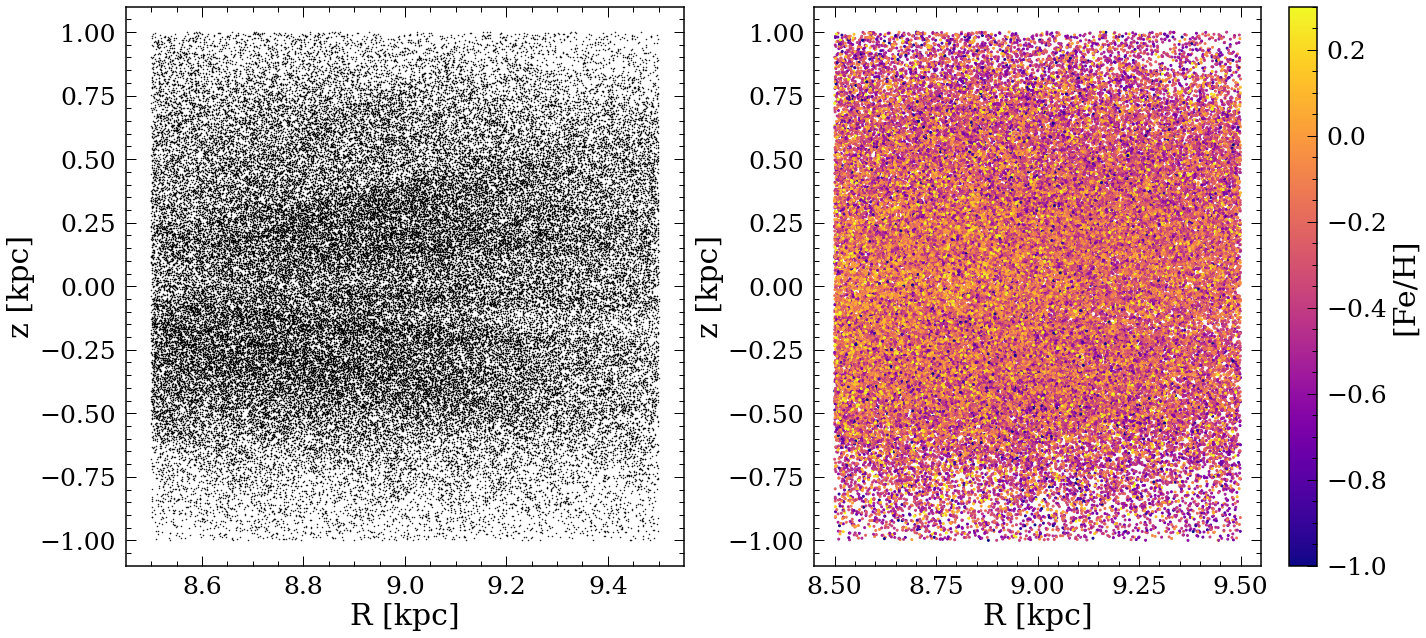

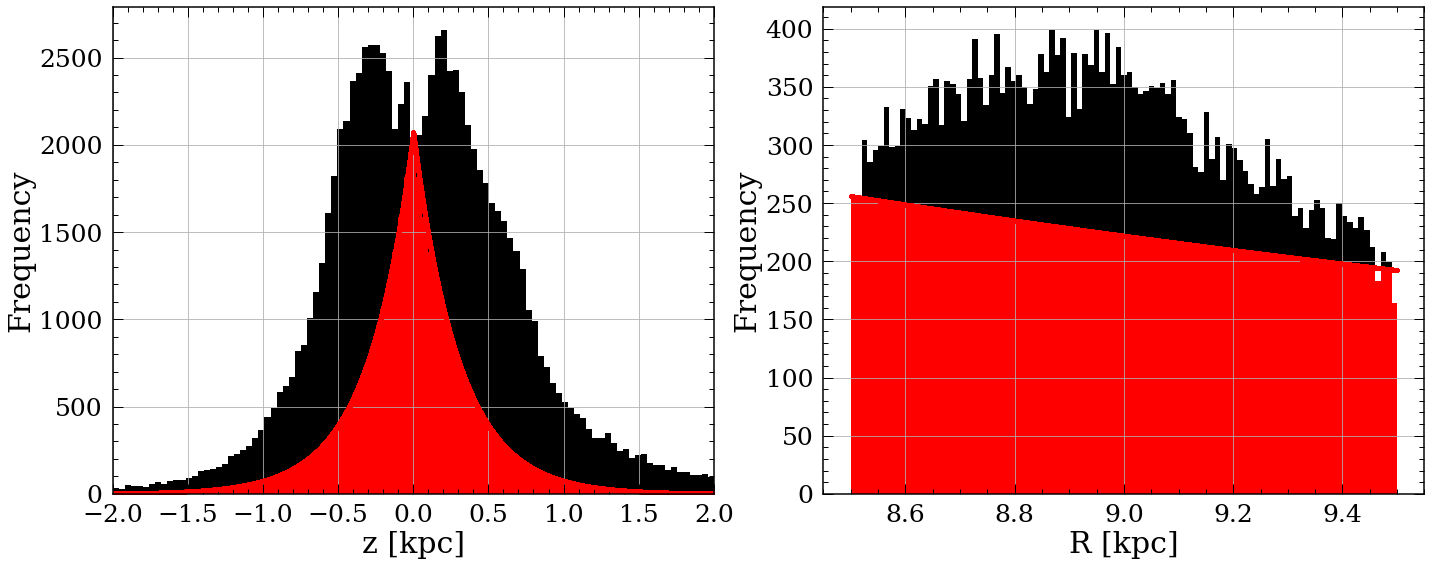

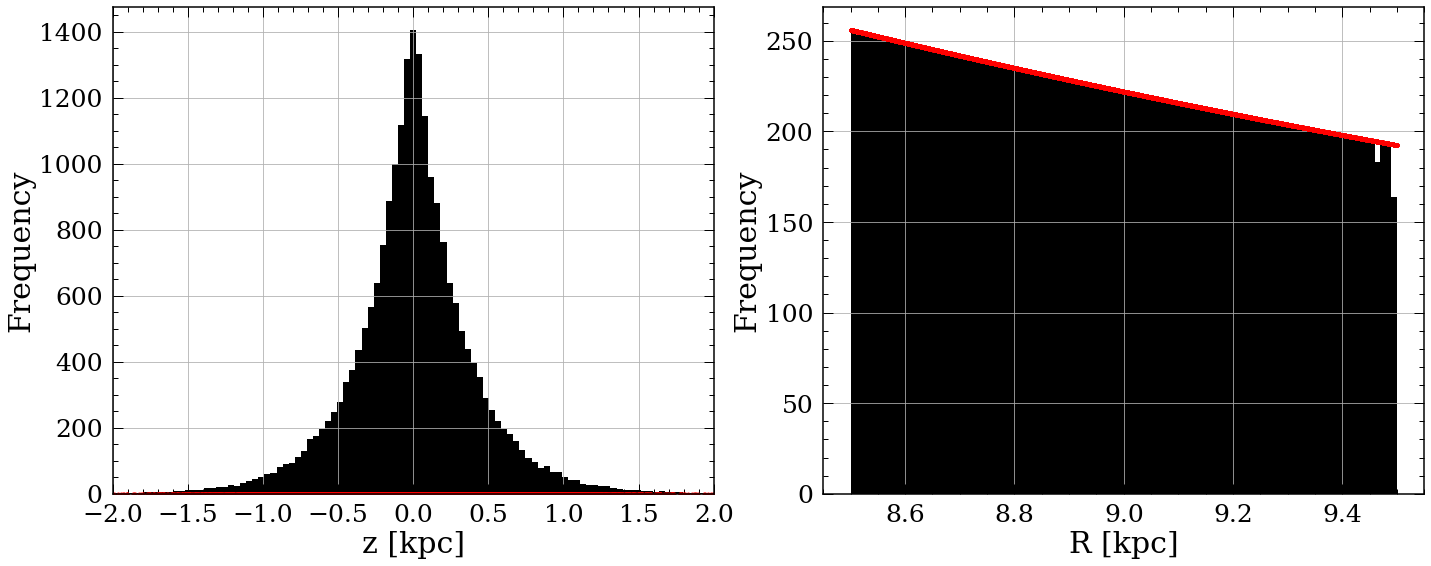

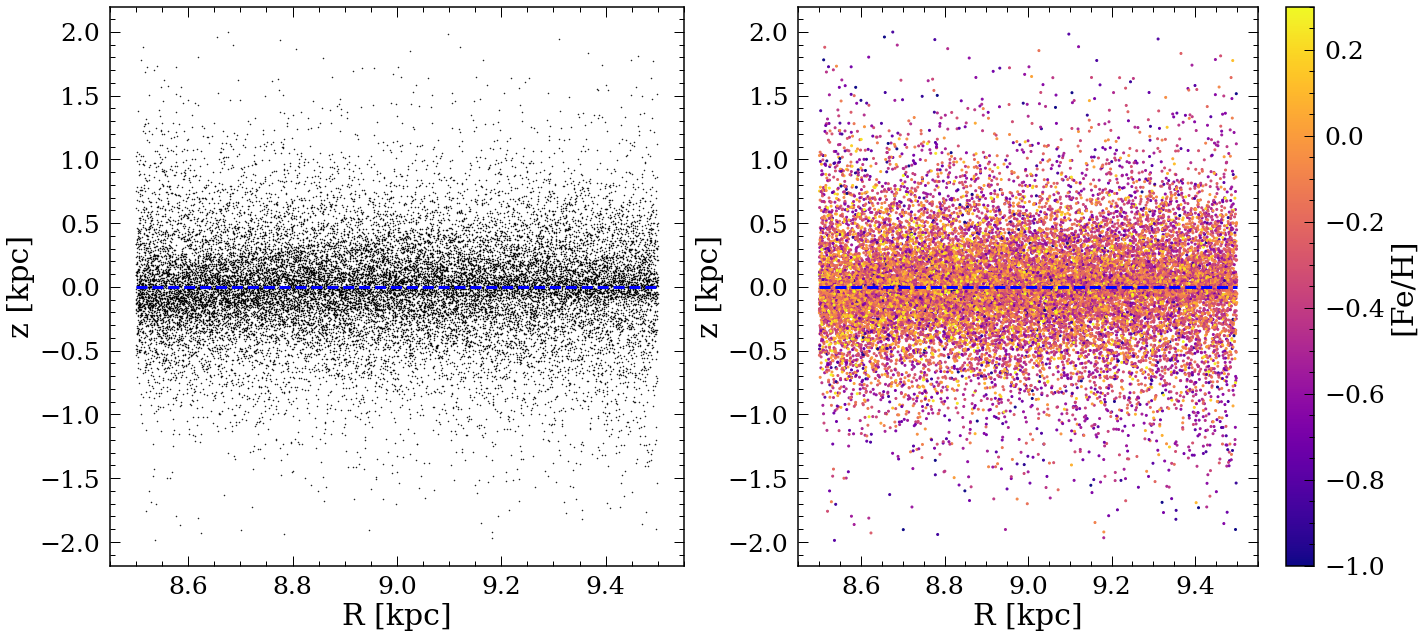

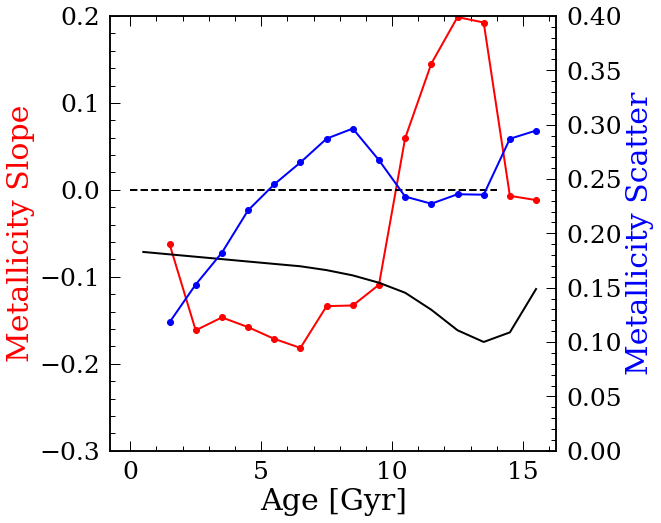

In [342]:
xrange = [8.5,9.5]
agebincalc = np.linspace(0,16,17)
#zsel_scale = 2500
#Rsel_scale = 2500

############## define selection function
def sel_fn(z, mult, scale):
    return mult*np.exp(-abs(z)/scale)
############## define selection function



"""sub = Table.read('subgiant_fullparam_update.fits', format='fits')
sub = sub.to_pandas()"""

print('Before eccentricity cut:')
print(len(sub), len(sub_rbir))
sub_rbir = sub_rbir.loc[abs(sub_rbir['ECC'])<0.5].reset_index(drop=True)
sub = sub.loc[abs(sub['ECC'])<0.5].reset_index(drop=True)

print('After eccentricity cut:')
print(len(sub), len(sub_rbir))

sub_check = sub.loc[(sub['R']>xrange[0])&(sub['R']<xrange[1])]
m = (abs(sub_check['Z'])<1)&(sub_check['AGE_ERR']<np.diff(agebincalc)[0])
m = m&(sub_check['AGE']>1.5)

plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
plt.plot(sub_check['R'][m], sub_check['Z'][m], 'k.', markersize=1)
plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')

plt.subplot(1,2,2)
plt.scatter(sub_check['R'][m], sub_check['Z'][m], 
            c = sub_check['FEH'][m], s=4, cmap='plasma', vmin=-1,
           vmax=0.3)
plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')
cb = plt.colorbar()
cb.set_label('[Fe/H]')
plt.tight_layout()


##### select stars 
import random
m_sel = np.zeros(len(sub_check))
zbins = np.linspace(-2,2,100)
Rbins = np.linspace(xrange[0], xrange[1], 100)

zsel_scale = sum(abs(sub_check['Z'])<np.diff(zbins)[0])/2

for i in range(len(zbins)-1):
    m_sing = ((sub_check['Z'])>zbins[i])&((sub_check['Z'])<zbins[i+1])
    # number of stars to get
    nubstars = int(sel_fn((zbins[i]+zbins[i+1])/2, zsel_scale, 0.3))
    
    # get all the stars randomly
    randnum = list(range(sum(m_sing)))
    random.shuffle(randnum)
    random_ind = np.zeros(len(randnum))
    random_ind[randnum[:nubstars]] = 1
    
    m_sel[m_sing] = random_ind
m_sel = np.array(m_sel, dtype=bool)

# plot final histogram
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
(sub_check['Z']).hist(bins=zbins, color='k')
plt.plot((sub_check['Z']), sel_fn(sub_check['Z'], zsel_scale, 0.3), 'r.')
(sub_check['Z'][m_sel]).hist(bins=zbins, color='r')
plt.xlabel('z [kpc]')
plt.ylabel('Frequency')
plt.xlim([-2,2])

plt.subplot(1,2,2)
sub_check = sub_check[m_sel].reset_index(drop=True)
m_sel = np.zeros(len(sub_check))

Rsel_scale = sum((sub_check['R']>Rbins[0])&(sub_check['R']<Rbins[1]))/np.exp(-abs(xrange[0])/3.5)
print(zsel_scale, Rsel_scale)

for i in range(len(Rbins)-1):
    m_sing = (abs(sub_check['R'])>Rbins[i])&(abs(sub_check['R'])<Rbins[i+1])
    # number of stars to get
    nubstars = int(sel_fn((Rbins[i]+Rbins[i+1])/2, Rsel_scale, 3.5))
    
    # get all the stars randomly
    randnum = list(range(sum(m_sing)))
    random.shuffle(randnum)
    random_ind = np.zeros(len(randnum))
    random_ind[randnum[:nubstars]] = 1
    
    m_sel[m_sing] = random_ind
m_sel = np.array(m_sel, dtype=bool)

abs(sub_check['R']).hist(bins=Rbins, color='k')
plt.plot(abs(sub_check['R']), 
         sel_fn(sub_check['R'], Rsel_scale, 3.5), 'r.')
abs(sub_check['R'][m_sel]).hist(bins=Rbins, color='r')
plt.xlabel('R [kpc]')
plt.ylabel('Frequency')
plt.tight_layout()




### final final histogram
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
(sub_check['Z'][m_sel]).hist(bins=zbins, color='k')
plt.plot((sub_check['Z'][m_sel]), 
         sel_fn(sub_check['Z'][m_sel], 
                sum(abs(sub_check['Z'][m_sel])<zbins[1])/2, 0.3), 'r.')
plt.xlabel('z [kpc]')
plt.ylabel('Frequency')
plt.xlim([-2,2])

plt.subplot(1,2,2)
abs(sub_check['R'][m_sel]).hist(bins=Rbins, color='k')
plt.plot(abs(sub_check['R'][m_sel]), 
         sel_fn(sub_check['R'][m_sel], Rsel_scale, 3.5), 'r.')
plt.xlabel('R [kpc]')
plt.ylabel('Frequency')
plt.tight_layout()
print(sum(m_sel))



#### plot R-z 
plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
plt.plot(sub_check['R'][m_sel], sub_check['Z'][m_sel], 'k.', markersize=1)
plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')
plt.plot(xrange, [0, 0], 'b--', linewidth=3)

plt.subplot(1,2,2)
plt.scatter(sub_check['R'][m_sel], sub_check['Z'][m_sel], 
            c = sub_check['FEH'][m_sel], s=4, cmap='plasma', vmin=-1,
           vmax=0.3)
plt.plot(xrange, [0, 0], 'b--', linewidth=3)
plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')
cb = plt.colorbar()
cb.set_label('[Fe/H]')
plt.tight_layout()



#### get slope for selected sample
ages, slopes, fehscatter = monoage_line(sub_check['FEH'].values[m_sel], 
                                        sub_check['R'].values[m_sel], 
                                        sub_check['AGE'].values[m_sel],
                                        agebin=agebincalc,
                                        xlims=xrange,
                                       feherr=sub_check['FEH_ERR'].values[m_sel],
                                       plotlegend=False,pltfig=False)

(sub_check[m_sel].reset_index(drop=True)).to_csv('Xiang_fitline.csv',index=False)

sub_check = sub_check[m_sel].reset_index(drop=True)
print('full sample', len(sub_check))
print(max(sub_check['AGE']))
sub_check = pd.merge(sub_check, 
                     pd.read_csv('Xiang_elements.csv')[['MG_FE','MG_FE_ERR','SPECID']],
                    left_on='SPECID', right_on='SPECID',how='inner')
sub_check = sub_check.loc[abs(sub_check['MG_FE'])<100].dropna(subset=['MG_FE','MG_FE_ERR']).reset_index(drop=True)
print('with [Mg/Fe]', len(sub_check))
print(max(sub_check['AGE']))


ages_afe, slopes_afe, fehscatter_afe = monoage_line(sub_check['MG_FE'].values, 
                                        sub_check['R'].values, 
                                        sub_check['AGE'].values,
                                        agebin=agebincalc,
                                        xlims=xrange,
                                       feherr=sub_check['MG_FE_ERR'].values,
                                       plotlegend=False,pltfig=False)



sub_check = sub_rbir.loc[abs(sub_rbir['Z'])<1]
sub_check = sub_check.loc[(sub_check['AGE_ERR']<np.diff(agebincalc)[0])]
sub_check = sub_check.loc[(sub_check['AGE']>1.5)].reset_index(drop=True)

ages, slopes_rbir, fehscatter_rbir = monoage_line(sub_check['FEH'].values, 
                                        sub_check['Rb'].values, 
                                        sub_check['AGE'].values,
                                        agebin=agebincalc,
                                        xlims=[0,15],
                                       feherr=sub_check['FEH_ERR'].values,
                                       plotlegend=False,pltfig=False)


ivanslope = pd.read_csv('rb_slope.csv')
ivanslope_int = interp1d(np.append(ivanslope['t_model    '].values, 16),
                        np.append(ivanslope['      slope'].values, 
                                  ivanslope['      slope'].values[-1]),
                         kind='cubic')
slopes_rbir = ivanslope_int(ages)


#sub_check = sub_check.dropna(subset=['ALPHA_FE','ALPHA_FE_ERR'])
sub_check = pd.merge(sub_check, 
                     pd.read_csv('Xiang_elements.csv')[['MG_FE','MG_FE_ERR','SPECID']],
                    left_on='SPECID', right_on='SPECID',how='inner')
sub_check = sub_check.loc[abs(sub_check['MG_FE'])<100].dropna(subset=['MG_FE','MG_FE_ERR']).reset_index(drop=True)



ages_afe, slopesafe_rbir, fehscatterafe_rbir = monoage_line(sub_check['MG_FE'].values, 
                                        sub_check['Rb'].values, 
                                        sub_check['AGE'].values,
                                        agebin=agebincalc,
                                        xlims=[0,15],
                                       feherr=sub_check['MG_FE_ERR'].values,
                                       plotlegend=False,pltfig=False)

plt.figure(figsize=(8,8))
plt.plot(ages, slopes, 'r-o')
plt.plot(ages, slopes_rbir, 'k-',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('Metallicity Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.3, 0.2])

plt.twinx()
plt.plot(ages, fehscatter, 'b-o')
plt.ylim([0.,0.4])
plt.ylabel('Metallicity Scatter', color='b',zorder=5)




# Use slope/scatter derived from MCMC

### [Fe/H]

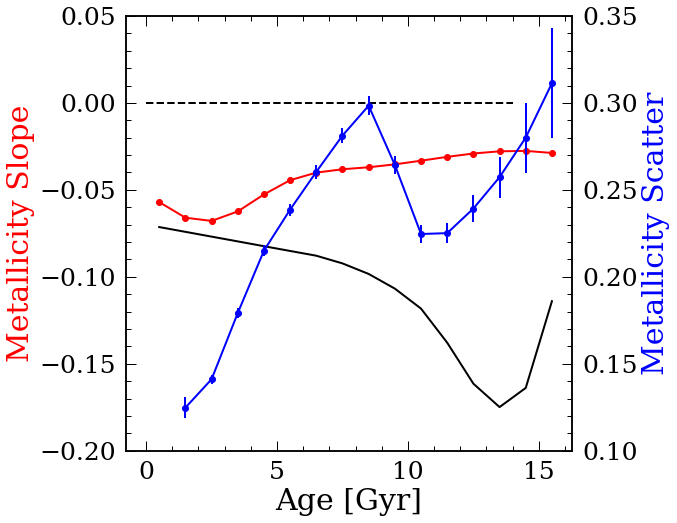

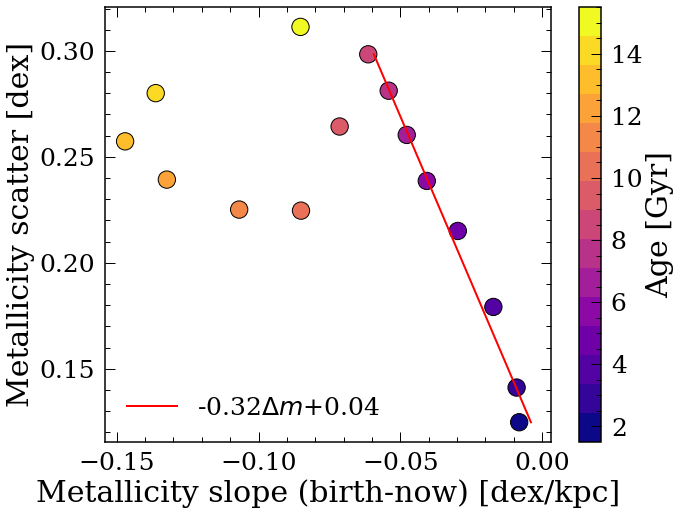

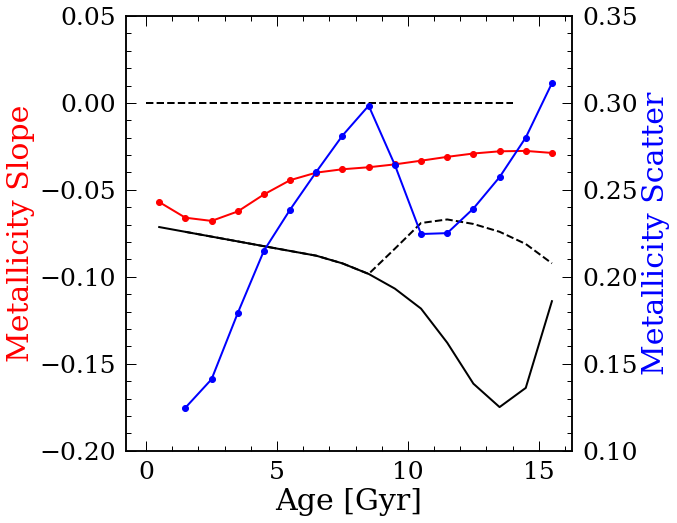

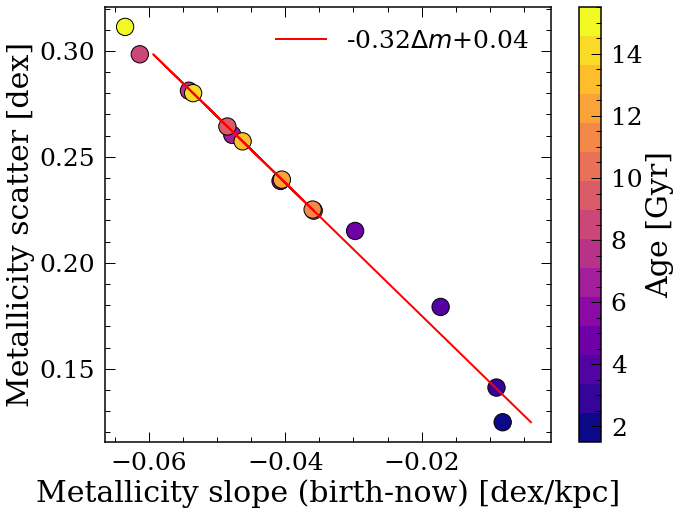

In [302]:
from scipy.interpolate import interp1d
agefit = 15

df = pd.read_csv('Xiang_selslope.csv')
ages, slopes, fehscatter = df['age'].values,df['slopes'].values,df['fehscatter'].values
slopes_err, fehscatter_err = df['slopes_err'], df['fehscatter_err']

plt.figure(figsize=(8,8))
#plt.errorbar(ages, slopes, yerr=slopes_err, fmt='r--o')

age_and = [0.5, 1.5, 3, 5, 8.5, 12, 16]
slopes_and = [-0.057, -0.066, -0.066, -0.048, -0.037, -0.03, -0.03]

slopes_fit = interp1d(age_and, slopes_and, kind='cubic')
slopes = slopes_fit(ages)
slopes_err = np.zeros(len(ages))


plt.errorbar(ages, slopes, yerr=slopes_err, fmt='r-o')
plt.plot(ages, slopes_rbir, 'k-',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('Metallicity Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.2, 0.05])

plt.twinx()
plt.errorbar(ages, fehscatter, yerr=fehscatter_err, fmt='b-o')
plt.ylim([0.1,0.35])
plt.ylabel('Metallicity Scatter', color='b',zorder=5)


df = pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir'])


df = df.dropna(subset=['slopes','fehscatter']).reset_index(drop=True)

df['slopes_rbir'] = df['slopes_rbir']
m2 = (df['age']<9)

plt.figure(figsize=(10,8))
plt.scatter(df['slopes_rbir']-df['slopes'], df['fehscatter'], 
           c=df['age'], s=300, edgecolor='k', 
            cmap=plt.get_cmap('plasma', len(df)))
p = fitpoints(df['fehscatter'][m2], (df['slopes_rbir']-df['slopes'])[m2])
plt.xlabel('Metallicity slope (birth-now) [dex/kpc]')
plt.ylabel('Metallicity scatter [dex]')
plt.plot(p((df['fehscatter']))[m2],
         (df['fehscatter'])[m2], 'r-', 
         label="%.2f$Δm$+%.2f"%(p[1],p[0]))

slope_rbir_infer = np.zeros(len(df))
slope_rbir_infer[~m2] = p((df['fehscatter'][~m2]))+df['slopes'][~m2]
slope_rbir_infer[m2] = df['slopes_rbir'][m2]

df['slope_rbir_infer'] = slope_rbir_infer

#print(df)

cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.legend()





plt.figure(figsize=(8,8))
plt.plot(ages, slopes, 'r-o')
plt.plot(ages, slopes_rbir, 'k-',zorder=5)
plt.plot(df['age'], df['slope_rbir_infer'], 'k--',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('Metallicity Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.2, 0.05])

plt.twinx()
plt.plot(ages, fehscatter, 'b-o')
plt.ylim([0.1,0.35])
plt.ylabel('Metallicity Scatter', color='b',zorder=5)




plt.figure(figsize=(10,8))
plt.scatter(df['slope_rbir_infer']-df['slopes'], df['fehscatter'], 
           c=df['age'], s=300, edgecolor='k', 
            cmap=plt.get_cmap('plasma', len(df)))
m2 = (df['age']<agefit)

p = fitpoints(df['fehscatter'][m2], (df['slope_rbir_infer']-df['slopes'])[m2])

plt.xlabel('Metallicity slope (birth-now) [dex/kpc]')
plt.ylabel('Metallicity scatter [dex]')
plt.plot(p((df['fehscatter']))[m2],
         (df['fehscatter'])[m2], 'r-', 
         label="%.2f$Δm$+%.2f"%(p[1],p[0]))

#df['slope_rbir_infer'] = p((df['fehscatter']))+df['slopes']

cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.legend()

In [303]:
#np.log(1)

### Check [$\alpha$/Fe]

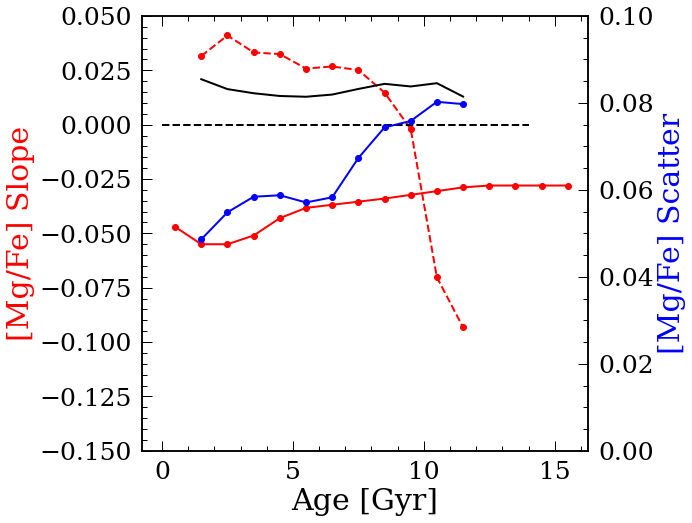

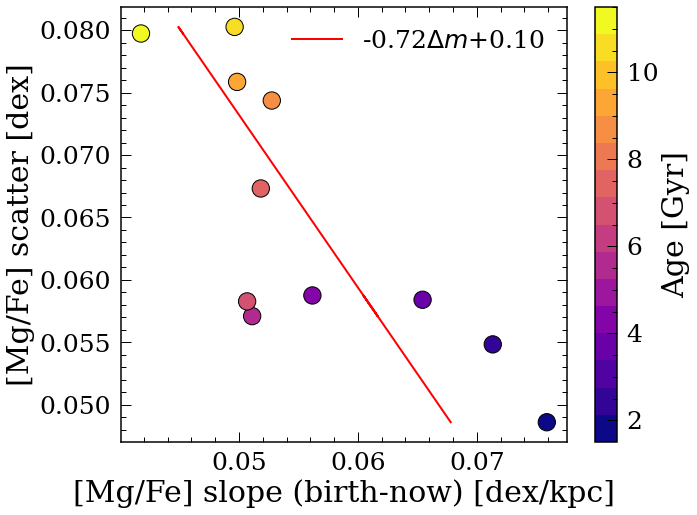

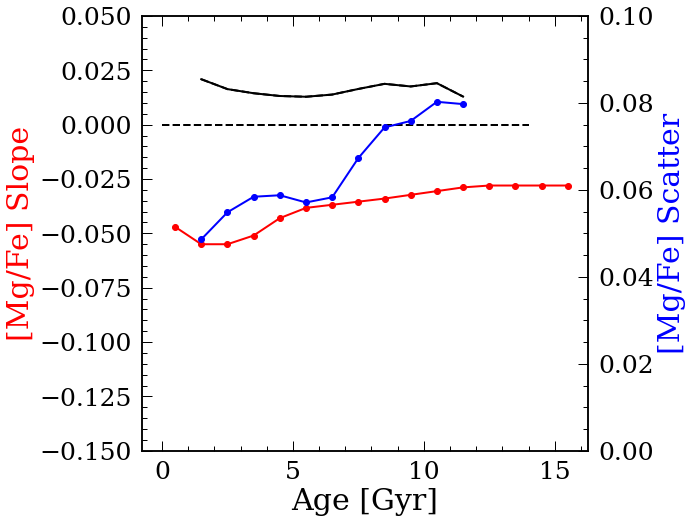

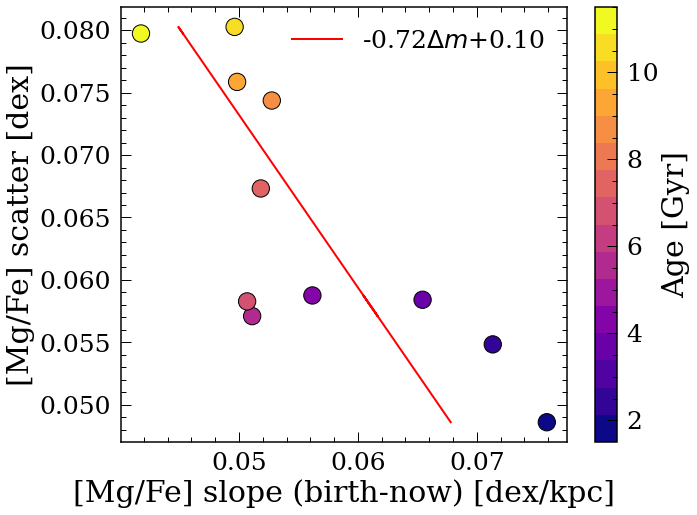

In [354]:
from scipy.interpolate import interp1d
agefit = 15

df = pd.read_csv('Xiang_selslope_afe.csv')
ages_afe, slopes_afe, fehscatter_afe = df['age'].values,df['slopes'].values,df['fehscatter'].values
slopesafe_err, fehscatterafe_err = df['slopes_err'], df['fehscatter_err']

plt.figure(figsize=(8,8))
plt.errorbar(ages_afe, slopes_afe, yerr=slopes_err, fmt='r--o')

age_and = [0.5, 1.5, 3, 5, 8.5, 12, 16]
slopes_and = [-0.047, -0.055, -0.055, -0.039, -0.034, -0.028, -0.028]

slopes_fit = interp1d(age_and, slopes_and)
slopes_afe = slopes_fit(ages_afe)
slopes_err = np.zeros(len(ages_afe))

plt.errorbar(ages_afe, slopes_afe, fmt='r-o')
plt.plot(ages_afe, slopesafe_rbir, 'k-',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('[Mg/Fe] Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.15, 0.05])

plt.twinx()
#plt.errorbar(ages_afe, fehscatter_afe, yerr=fehscatterafe_err, fmt='b-o')
plt.errorbar(ages_afe, fehscatter_afe, fmt='b-o')
plt.ylim([0.,0.1])
plt.ylabel('[Mg/Fe] Scatter', color='b',zorder=5)


df_afe = pd.DataFrame(np.array((ages_afe, slopes_afe, fehscatter_afe, slopesafe_rbir, fehscatterafe_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir'])


df_afe = df_afe.dropna(subset=['slopes','fehscatter']).reset_index(drop=True)

df_afe['slopes_rbir'] = df_afe['slopes_rbir']
m2 = (df_afe['age']<20)

plt.figure(figsize=(10,8))
plt.scatter(df_afe['slopes_rbir']-df_afe['slopes'], df_afe['fehscatter'], 
           c=df_afe['age'], s=300, edgecolor='k', 
            cmap=plt.get_cmap('plasma', len(df)))
p = fitpoints(df_afe['fehscatter'][m2], (df_afe['slopes_rbir']-df_afe['slopes'])[m2])
plt.xlabel('[Mg/Fe] slope (birth-now) [dex/kpc]')
plt.ylabel('[Mg/Fe] scatter [dex]')
plt.plot(p((df_afe['fehscatter']))[m2],
         (df_afe['fehscatter'])[m2], 'r-', 
         label="%.2f$Δm$+%.2f"%(p[1],p[0]))


slope_rbir_infer = np.zeros(len(df_afe))
slope_rbir_infer[~m2] = p((df_afe['fehscatter'][~m2]))+df_afe['slopes'][~m2]
slope_rbir_infer[m2] = df_afe['slopes_rbir'][m2]

df_afe['slope_rbir_infer'] = slope_rbir_infer

#print(df)

cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.legend()





plt.figure(figsize=(8,8))
plt.plot(ages_afe, slopes_afe, 'r-o')
plt.plot(ages_afe, slopesafe_rbir, 'k-',zorder=5)
plt.plot(df_afe['age'], df_afe['slope_rbir_infer'], 'k--',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('[Mg/Fe] Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.15, 0.05])

plt.twinx()
plt.plot(ages_afe, fehscatter_afe, 'b-o')
plt.ylim([0.,0.1])
plt.ylabel('[Mg/Fe] Scatter', color='b',zorder=5)




plt.figure(figsize=(10,8))
plt.scatter(df_afe['slope_rbir_infer']-df_afe['slopes'], df_afe['fehscatter'], 
           c=df_afe['age'], s=300, edgecolor='k', 
            cmap=plt.get_cmap('plasma', len(df)))
m2 = (df_afe['age']<agefit)

p = fitpoints(df_afe['fehscatter'][m2], (df_afe['slope_rbir_infer']-df_afe['slopes'])[m2])

plt.xlabel('[Mg/Fe] slope (birth-now) [dex/kpc]')
plt.ylabel('[Mg/Fe] scatter [dex]')
plt.plot(p((df_afe['fehscatter']))[m2],
         (df_afe['fehscatter'])[m2], 'r-', 
         label="%.2f$Δm$+%.2f"%(p[1],p[0]))

#df['slope_rbir_infer'] = p((df['fehscatter']))+df['slopes']

cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.legend()


# use inferred slope to get Rbir


In [305]:
# get Fe/H in solar neiborhood
agebins = np.linspace(0,16,17)
fehave = np.zeros(len(agebins)-1)
fehave_age = np.zeros(len(agebins)-1)
for i in range(len(agebins)-1):
    sub_sing = sub_rbir.loc[(sub_rbir['AGE']>agebins[i])&(sub_rbir['AGE']<agebins[i+1])]
    sub_sing = sub_sing.loc[abs(sub_sing['Rb']-8.2)<0.5]
    fehave[i] = np.median(sub_sing['FEH'].dropna())
fehave_age = (agebins[1:]+agebins[:-1])/2
    
    
fehevl = pd.read_table('feh_t_sol.txt', delim_whitespace=True,
                      names=['0','1'])
fehave_age, fehave = fehevl['0'].values, fehevl['1'].values

fehave = fehave+0.075*8.2

/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, '[Fe/H]$_{0}$ [dex]')

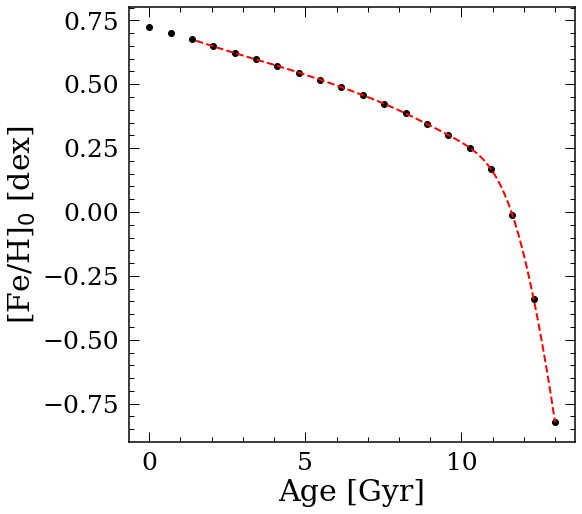

In [306]:
plt.figure(figsize=(8,8))
mfit = (fehave==fehave)
ave_inf = interp1d(fehave_age[mfit], 
                   fehave[mfit], kind='cubic')

plt.plot(fehave_age, fehave, 'ko')
plt.plot(np.linspace(1.5,13,100), ave_inf(np.linspace(1.5,13,100)), 'r--')
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]$_{0}$ [dex]')

15
15


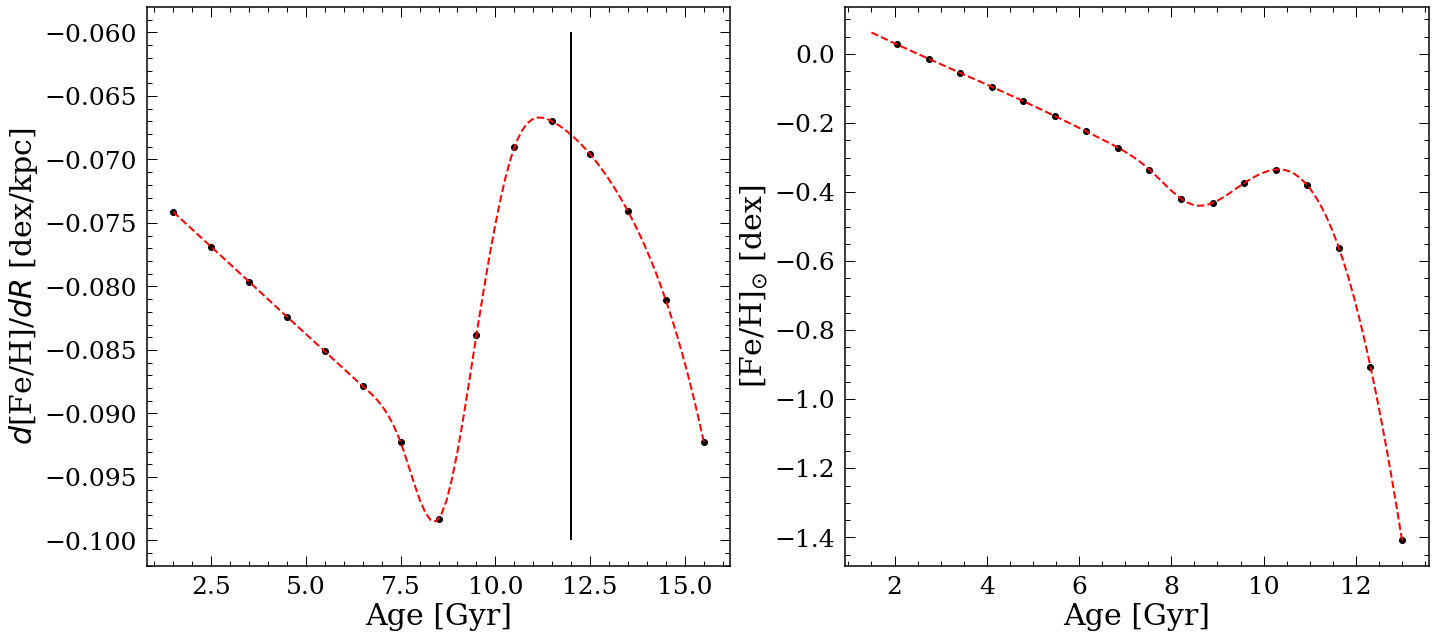

In [311]:
from scipy.interpolate import interp1d

print(len(df))
mfit = (df['slope_rbir_infer']==df['slope_rbir_infer'])
print(sum(mfit))

slope_inf = interp1d(df['age'][mfit], df['slope_rbir_infer'][mfit], 
                     kind='cubic')


"""ivanslope['slope_cor'] = np.nan
m = (ivanslope['t_model    ']>1.5)
ivanslope['slope_cor'][m] = slope_inf(ivanslope['t_model    '][m])

m2 = (df['age'][mfit]>12)
ivanslope_ext = df[mfit][m2][['age', 'slope_rbir_infer']]
ivanslope_ext = ivanslope_ext.rename(columns={'slope_rbir_infer':'slope_cor',
                             'age':'t_model    '})
ivanslope = pd.merge(ivanslope, ivanslope_ext, how='outer')
ivanslope.sort_values('t_model    ').to_csv('rb_slope.csv', index=False)"""


plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
plt.plot(df['age'][mfit], df['slope_rbir_infer'][mfit], 'ko')
#plt.plot(ivanslope['t_model    '], ivanslope['slope_cor'], 'bo')
plt.plot(np.linspace(1.5,15.5,100), slope_inf(np.linspace(1.5,15.5,100)), 'r--')
plt.xlabel('Age [Gyr]')
plt.ylabel('$d$[Fe/H]/$dR$ [dex/kpc]')
plt.vlines(12, ymin=-0.1, ymax=-0.06, color='k')


plt.subplot(1,2,2)
m = (fehave_age>1.5)&(fehave_age<15.5)
plt.plot(fehave_age[m], slope_inf(fehave_age[m])*8.2+ave_inf(fehave_age[m]), 'ko')
plt.plot(np.linspace(1.5,13,100), 
         slope_inf(np.linspace(1.5,13,100))*8.2+ave_inf(np.linspace(1.5,13,100)), 'r--')
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]$_{\odot}$ [dex]')

plt.tight_layout()



In [312]:
def getRb(age, feh, func_m, func_b):
    Rb = np.zeros(len(age))
    for i in trange(len(age)):
        m = func_m(age[i])
        b = func_b(age[i])
        #y = m*8.2
        #b = b-y
        
        Rb[i] = (feh[i]-b)/m
    return Rb
        

    

In [319]:
sub_tryRb = sub.loc[(sub['AGE']>1.5)&(sub['AGE']<12)].reset_index(drop=True)
#sub_tryRb = sub_tryRb.loc[abs(sub_tryRb['R']-8.2)<0.2].reset_index(drop=True)
sub_tryRb['Rb_new'] = getRb(sub_tryRb['AGE'].values, sub_tryRb['FEH'].values, slope_inf, ave_inf)


100%|██████████| 201440/201440 [00:08<00:00, 22510.38it/s]


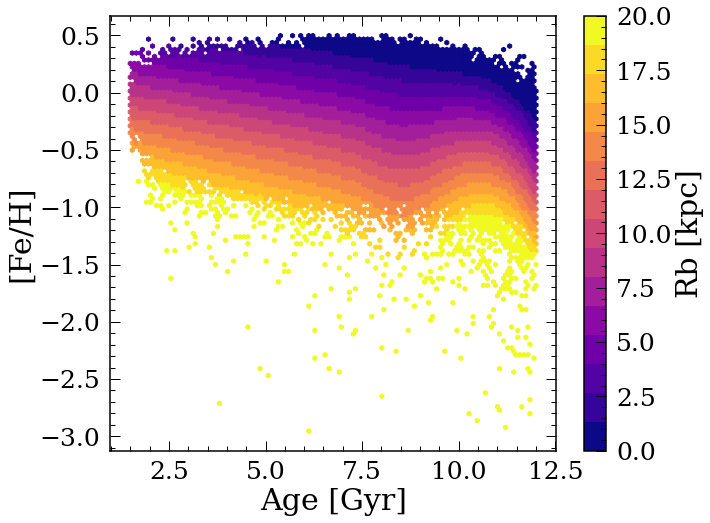

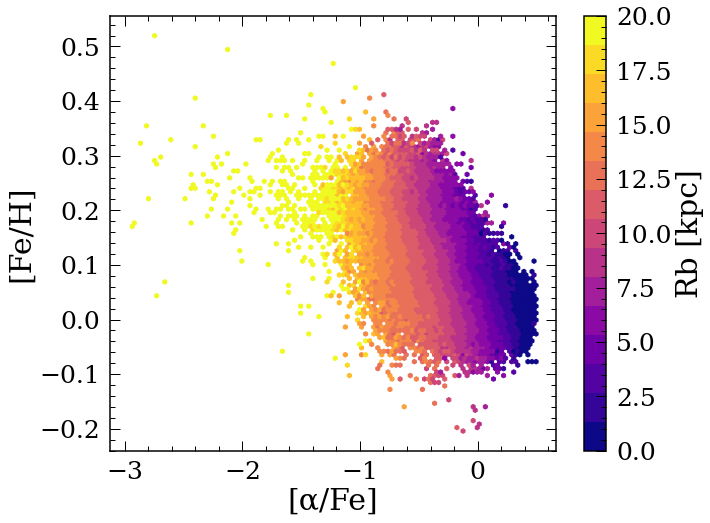

In [314]:
plt.figure(figsize=(10,8))
plt.hexbin(sub_tryRb['AGE'], sub_tryRb['FEH'], C=sub_tryRb['Rb_new'], 
          vmin=0, vmax=20, cmap=plt.get_cmap('plasma',15))
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]')
cb = plt.colorbar()
cb.set_label('Rb [kpc]')


plt.figure(figsize=(10,8))
plt.hexbin(sub_tryRb['FEH'], sub_tryRb['ALPHA_FE'], C=sub_tryRb['Rb_new'], 
          vmin=0, vmax=20, cmap=plt.get_cmap('plasma',15))
plt.xlabel('[α/Fe]')
plt.ylabel('[Fe/H]')
cb = plt.colorbar()
cb.set_label('Rb [kpc]')



0.004010230825097098


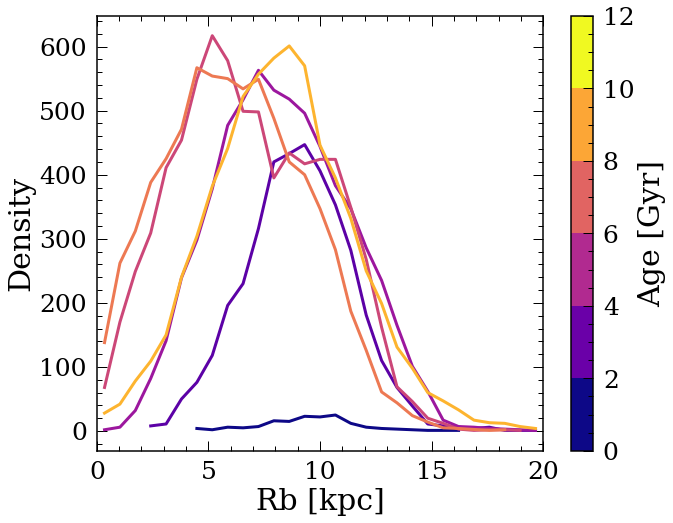

In [318]:
agebin_Rb = np.linspace(0,12,7)
agebin_colors = getcolor(agebin_Rb)
plt.figure(figsize=(10,8))
#plt.hist(sub_tryRb['Rb'], color='k', alpha=0.2, bins=np.linspace(0,20,100))
for i in range(len(agebin_Rb)-1):
    sub_sing = sub_tryRb.loc[(sub_tryRb['AGE']>agebin_Rb[i])&(sub_tryRb['AGE']<agebin_Rb[i+1])]
    fre, edg = np.histogram(sub_sing['Rb_new'], bins=np.linspace(0,20,30), density=False)
    
    m = (fre!=0)
    plt.plot((edg[1:]+edg[:-1])[m]/2, fre[m], color=agebin_colors[i], linewidth=3)
    
    """plt.vlines(np.mean(sub_sing['Rb_new']), ymin=0, ymax=800, color=agebin_colors[i],
              linewidth=3)"""
#plt.vlines(8.2, ymin=0, ymax=900, color='k')
plt.scatter(100,0,c=5,vmin=min(agebin_Rb),vmax=max(agebin_Rb),
           cmap=plt.get_cmap('plasma', len(agebin_Rb)-1))
plt.xlim([0,20])
plt.xlabel('Rb [kpc]')
plt.ylabel('Density')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')

print(sum(sub_tryRb['Rb_new']<0)/len(sub_tryRb['Rb_new']))


In [320]:

sub_tryRb = sub_tryRb.loc[abs(sub_tryRb['Z'])<1].reset_index(drop=True)
ages, rs, avrs_z = avr( sub_tryRb['Rb_new'].values, sub_tryRb['AGE'].values,
                       sub_tryRb['VZ'].values, 
                     rbin=np.linspace(2,12,7), agebin=np.linspace(2,20,15))

ages, rs, avrs_phi = avr(sub_tryRb['Rb_new'].values, sub_tryRb['AGE'].values,
                         sub_tryRb['VT'].values, 
                     rbin=np.linspace(2,12,7), agebin=np.linspace(2,20,15))

ages, rs, avrs_r = avr(sub_tryRb['Rb_new'].values, sub_tryRb['AGE'].values,
                       sub_tryRb['VR'].values, 
                     rbin=np.linspace(2,12,7), agebin=np.linspace(2,20,15))


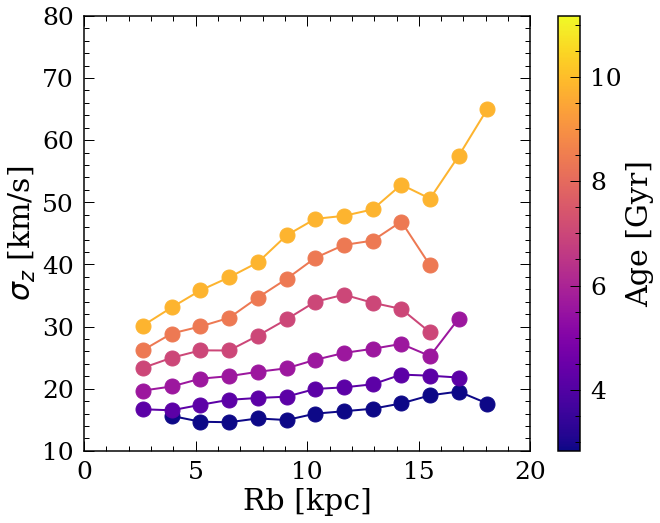

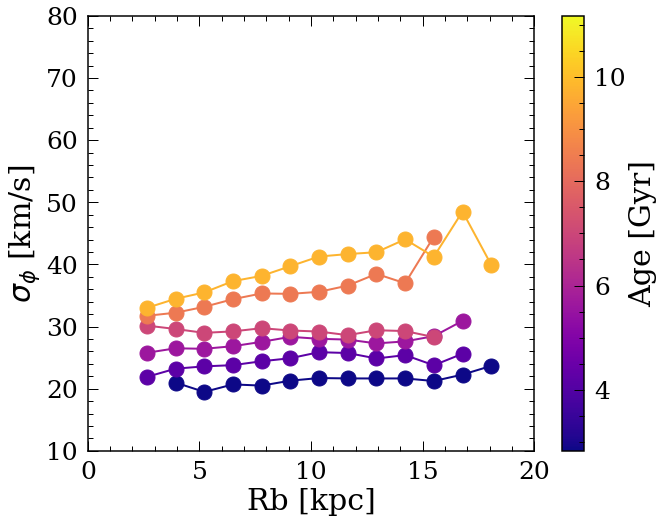

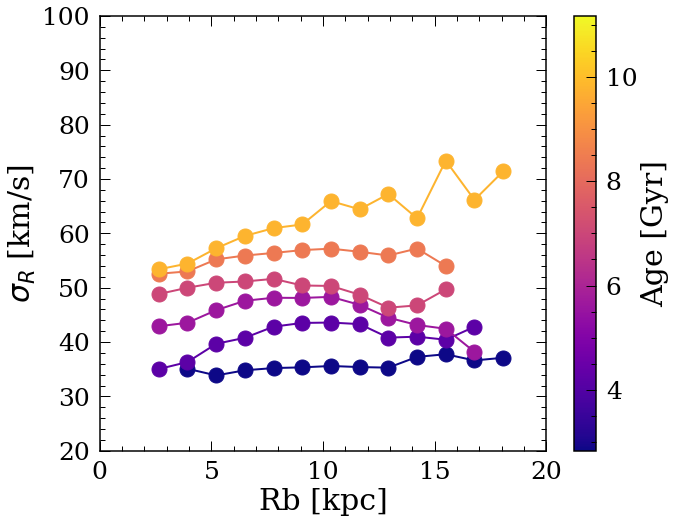

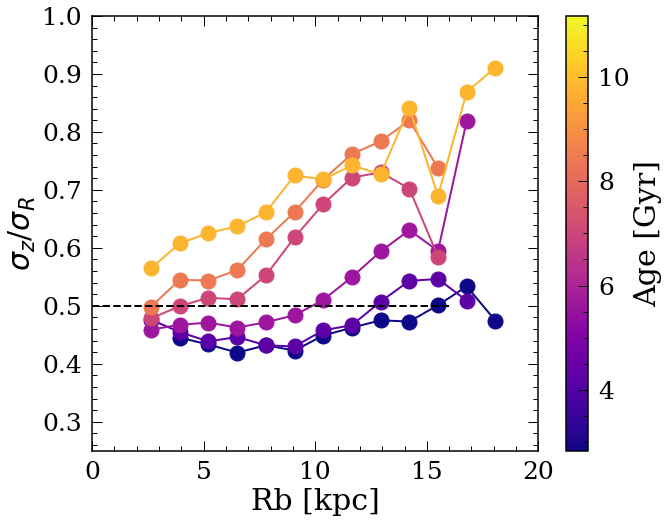

In [321]:

colors = getcolor(np.linspace(2,12,7))

plt.figure(figsize=(10,8))
for i in range(len(rs)):
    plt.plot(ages, avrs_z[i,:], 'o-', color=colors[i], label='Age = %.2f Gyr'%rs[i],
            markersize=15)
    plt.xlabel('Rb [kpc]')
    plt.ylabel('$σ_z$ [km/s]')
plt.scatter(-100, -100, c=1, vmin=min(rs), vmax=max(rs), cmap='plasma')
plt.ylim([10, 80])
plt.xlim([0,20])
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
#plt.legend()



plt.figure(figsize=(10,8))
for i in range(len(rs)):
    plt.plot(ages, avrs_phi[i,:], 'o-', color=colors[i], label='Age = %.2f Gyr'%rs[i],
            markersize=15)
    plt.xlabel('Rb [kpc]')
    plt.ylabel('$σ_ϕ$ [km/s]')
plt.ylim([10, 80])
plt.xlim([0,20])
plt.scatter(-100, -100, c=1, vmin=min(rs), vmax=max(rs), cmap='plasma')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
#plt.legend()



plt.figure(figsize=(10,8))
for i in range(len(rs)):
    plt.plot(ages, avrs_r[i,:], 'o-', color=colors[i], label='Age = %.2f Gyr'%rs[i],
            markersize=15)
    plt.xlabel('Rb [kpc]')
    plt.ylabel('$σ_R$ [km/s]')
plt.ylim([20, 100])
plt.xlim([0,20])
plt.scatter(-100, -100, c=1, vmin=min(rs), vmax=max(rs), cmap='plasma')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
#plt.legend()



plt.figure(figsize=(10,8))
for i in range(len(rs)):
    plt.plot(ages, avrs_z[i,:]/avrs_r[i,:], 'o-', color=colors[i], label='Age = %.2f Gyr'%rs[i],
            markersize=15)
    plt.xlabel('Rb [kpc]')
    plt.ylabel('$σ_z$/$σ_R$')
plt.ylim([0.25, 1])
plt.xlim([0,20])
plt.scatter(-100, -100, c=1, vmin=min(rs), vmax=max(rs), cmap='plasma')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
#plt.legend()

plt.plot([0,16], [0.5,0.5], 'k--')




In [322]:
#sub['Rmean'] = (sub['R_PERI']+sub['R_APO'])/2

sub_tryRb = sub_tryRb.loc[abs(sub_tryRb['Z'])<1].reset_index(drop=True)
ages, rs, avrs_z = avr(sub_tryRb['AGE'].values, sub_tryRb['Rb_new'].values, 
                       sub_tryRb['VZ'].values, 
                     rbin=np.linspace(2,15,5), agebin=np.linspace(0,12,13))

ages, rs, avrs_phi = avr(sub_tryRb['AGE'].values, sub_tryRb['Rb_new'].values, 
                         sub_tryRb['VT'].values, 
                     rbin=np.linspace(2,15,5), agebin=np.linspace(0,12,13))

ages, rs, avrs_r = avr(sub_tryRb['AGE'].values, sub_tryRb['Rb_new'].values, 
                       sub_tryRb['VR'].values, 
                     rbin=np.linspace(2,15,5), agebin=np.linspace(0,12,13))

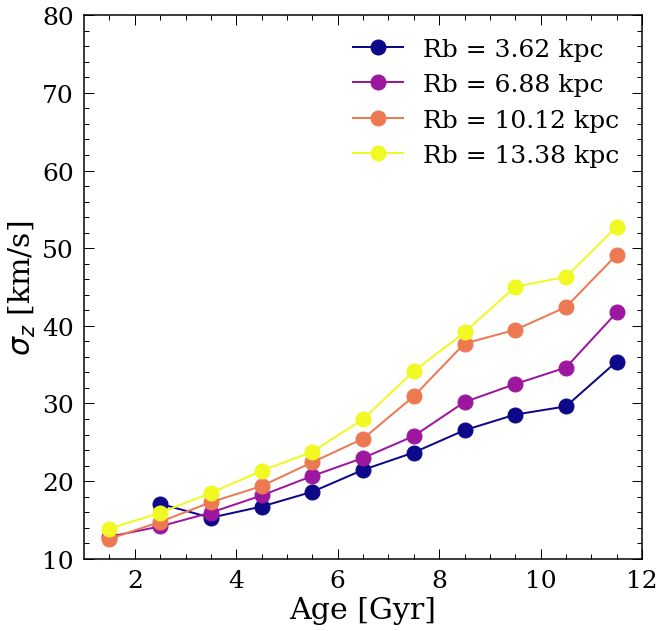

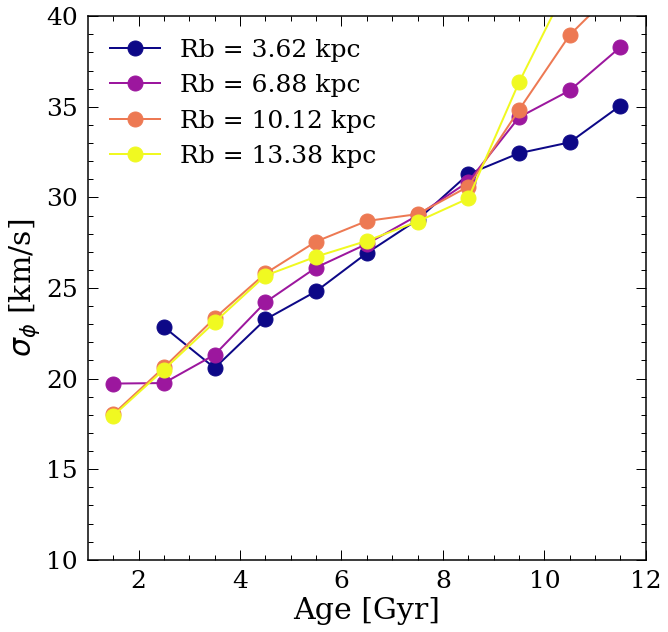

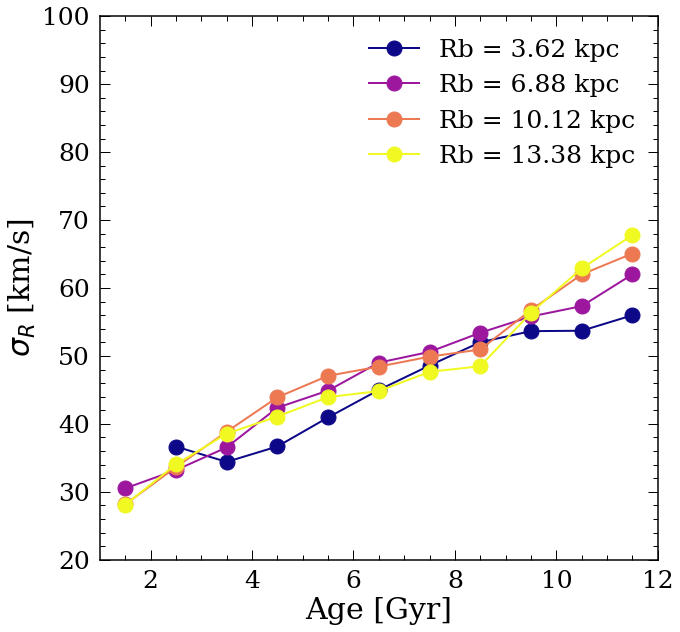

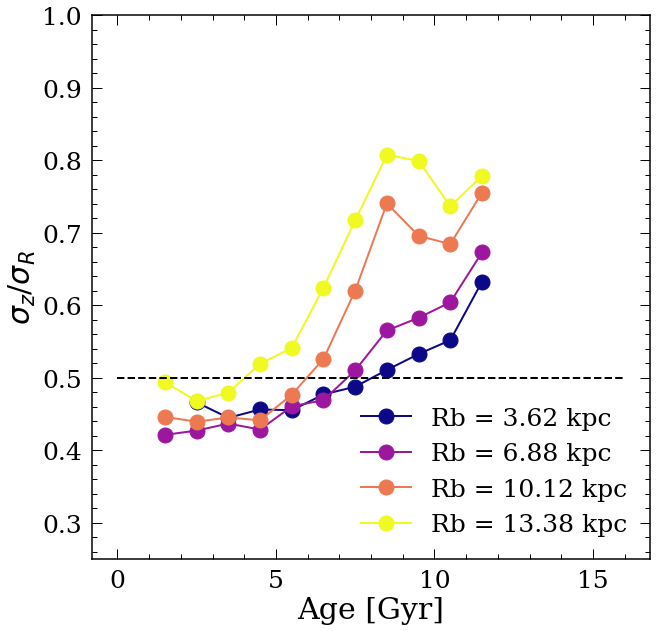

In [323]:

colors = getcolor(rs)

plt.figure()
for i in range(len(rs)):
    plt.plot(ages, avrs_z[i,:], 'o-', color=colors[i], label='Rb = %.2f kpc'%rs[i],
            markersize=15)
    plt.xlabel('Age [Gyr]')
    plt.ylabel('$σ_z$ [km/s]')
plt.ylim([10, 80])
plt.legend()



plt.figure()
for i in range(len(rs)):
    plt.plot(ages, avrs_phi[i,:], 'o-', color=colors[i], label='Rb = %.2f kpc'%rs[i],
            markersize=15)
    plt.xlabel('Age [Gyr]')
    plt.ylabel('$σ_ϕ$ [km/s]')
plt.ylim([10, 40])
plt.legend()



plt.figure()
for i in range(len(rs)):
    plt.plot(ages, avrs_r[i,:], 'o-', color=colors[i], label='Rb = %.2f kpc'%rs[i],
            markersize=15)
    plt.xlabel('Age [Gyr]')
    plt.ylabel('$σ_R$ [km/s]')
plt.ylim([20, 100])
plt.legend()



plt.figure()
for i in range(len(rs)):
    plt.plot(ages, avrs_z[i,:]/avrs_r[i,:], 'o-', color=colors[i], label='Rb = %.2f kpc'%rs[i],
            markersize=15)
    plt.xlabel('Age [Gyr]')
    plt.ylabel('$σ_z$/$σ_R$')
plt.legend()
plt.ylim([0.25, 1])

plt.plot([0,16], [0.5,0.5], 'k--')







In [324]:
def getmigration(r, rbir, age, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5]):
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    r, rbir, age = r[m], rbir[m], age[m]
    
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, rbir_sing = r[m], rbir[m]

        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                scatters[i,j] = np.nan
            else:
                r_sing_2, rbir_sing_2 = r_sing[m], rbir_sing[m]
                scatters[i,j] = np.std(rbir_sing_2-r_sing_2)

                
    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters




(0.0, 7.0)

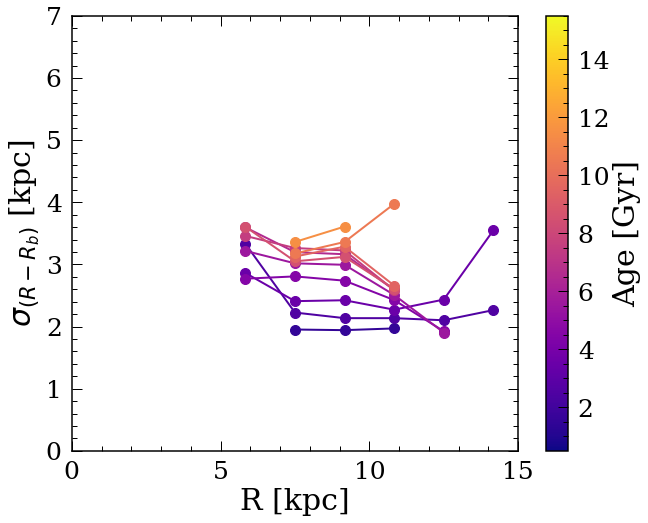

In [343]:
#agebincalc = np.linspace(0,14,10)
m = (abs(sub_tryRb['Z'])<0.5)
m = (abs(sub_tryRb['Z'])<1)&(sub_tryRb['AGE_ERR']<np.diff(agebincalc)[0])
m = m&(sub_tryRb['AGE']>1.5)

ages, rs, sigmaR = getmigration(sub_tryRb['R'].values[m], 
                                        sub_tryRb['Rb_new'].values[m], 
                                        sub_tryRb['AGE'].values[m],
                                        agebin=agebincalc,
                                        xlims=[0,15],rbin=10)



colors = getcolor(ages)
plt.figure(figsize=(10,8))
for i in range(len(ages)):
    plt.plot(rs, sigmaR[i,:], '-o', color=colors[i], markersize=10)
plt.scatter(-10,-10,c=0, vmin=min(ages), vmax=max(ages),cmap='plasma')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.xlabel('R [kpc]')
plt.ylabel('$σ_{(R-R_b)}$ [kpc]')
plt.xlim([0,15])
plt.ylim([0,7])






In [344]:
def movingMed_time(x,y,x_window,delta_x_window):
    # medians output
    x_med=np.zeros(len(x))
    y_med=np.zeros(len(y))

    # define the boundaries of the windows
    if len(x)==0:
        return x_med,y_med
    window_min=float(min(x))
    window_max=float(window_min+delta_x_window)
    
    # max time
    maxtime=max(x)
    
    # break when time window hits the end
    while window_max<=maxtime+x_window:
        seldf=(x>=window_min) & (x<=window_max) # get points between the window
        if sum(seldf)<10:
            x_med[seldf]=np.nan
            y_med[seldf]=np.nan
        else:
            x_med[seldf]=np.median(x[seldf]) # all values for these indices are subsituded with median time
            y_med[seldf]=np.median(y[seldf]) # all values for these indices are subsituded with median flux

        # slide the window
        window_min=window_min+delta_x_window
        window_max=window_max+delta_x_window
    return x_med, y_med

"plt.figure(figsize=(10,8))\nplt.hexbin(sub_tryRb['FEH'], sub_tryRb['ALPHA_FE'], cmap='binary',\n          extent=(-1.3,0.6,-0.2,0.4), gridsize=50, mincnt=1)\nfor i in range(len(Rbbin)-1):\n\n    m = (sub_tryRb['Rb_new']>Rbbin[i])&(sub_tryRb['Rb_new']<Rbbin[i+1])\n\n    age_amr_all, feh_amr_all = sub_tryRb['ALPHA_FE'].values[m], sub_tryRb['FEH'].values[m]\n    age_amr_all, feh_amr_all = zip(*sorted(zip(age_amr_all, feh_amr_all)))\n    age_amr_all, feh_amr_all = np.array(age_amr_all), np.array(feh_amr_all)\n    \n    age_amr, feh_amr = movingMed_time(age_amr_all, feh_amr_all,\n                                     0.04,0.04)\n    plt.plot(feh_amr, age_amr, '-o', color=color_amr[i], linewidth=2)\n    plt.xlim([-1.3,0.6])\n    plt.ylim([-0.2,0.4])\n    #print(sum(m))\n    #plt.title('%.2f kpc < Rb < %.2f kpc'%(Rbbin[i], Rbbin[i+1]), fontsize=25)\nplt.scatter(-100,-100, c=0, vmin=min(Rbbin), vmax=max(Rbbin), \n            cmap=plt.get_cmap('plasma', len(Rbbin)-1))\nplt.xlabel('[Fe/H]')\nplt

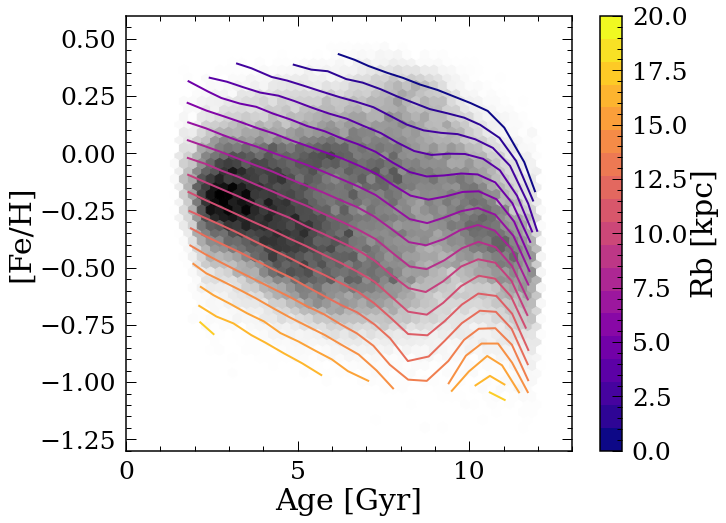

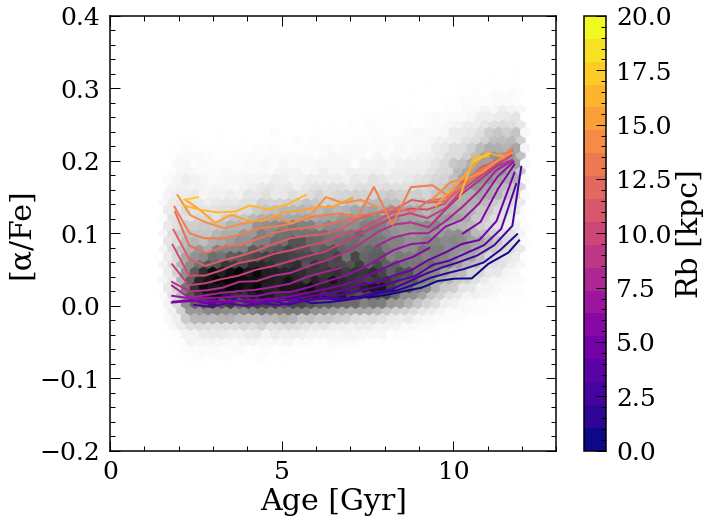

In [345]:
Rbbin = np.linspace(0,20,20)
color_amr = getcolor(range(len(Rbbin)))

plt.figure(figsize=(10,8))
plt.hexbin(sub_tryRb['AGE'], sub_tryRb['FEH'], cmap='binary',
          extent=(0,13,-1.3,0.6), gridsize=50, mincnt=1)
for i in range(len(Rbbin)-1):

    m = (sub_tryRb['Rb_new']>Rbbin[i])&(sub_tryRb['Rb_new']<Rbbin[i+1])
    """plt.hexbin(sub['AGE'][m], sub['FEH'][m], extent=(0,18,-2.5,0.5), cmap='jet',
            mincnt=1, gridsize=50)"""
    age_amr_all, feh_amr_all = sub_tryRb['AGE'].values[m], sub_tryRb['FEH'].values[m]
    age_amr_all, feh_amr_all = zip(*sorted(zip(age_amr_all, feh_amr_all)))
    age_amr_all, feh_amr_all = np.array(age_amr_all), np.array(feh_amr_all)
    age_amr, feh_amr = movingMed_time(age_amr_all, feh_amr_all,
                                     1,0.5)
    plt.plot(age_amr, feh_amr, '-', color=color_amr[i], linewidth=2)
    plt.xlim([0,13])
    plt.ylim([-1.3,0.6])
    #print(sum(m))
    #plt.title('%.2f kpc < Rb < %.2f kpc'%(Rbbin[i], Rbbin[i+1]), fontsize=25)
plt.scatter(-100,-100, c=0, vmin=min(Rbbin), vmax=max(Rbbin), 
            cmap=plt.get_cmap('plasma', len(Rbbin)-1))
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]')
cb = plt.colorbar()
cb.set_label('Rb [kpc]')
    

plt.figure(figsize=(10,8))
plt.hexbin(sub_tryRb['AGE'], sub_tryRb['ALPHA_FE'], cmap='binary',
          extent=(0,13,-0.2,0.4), gridsize=50, mincnt=1)
for i in range(len(Rbbin)-1):

    m = (sub_tryRb['Rb_new']>Rbbin[i])&(sub_tryRb['Rb_new']<Rbbin[i+1])
    """plt.hexbin(sub['AGE'][m], sub['FEH'][m], extent=(0,18,-2.5,0.5), cmap='jet',
            mincnt=1, gridsize=50)"""
    age_amr_all, feh_amr_all = sub_tryRb['AGE'].values[m], sub_tryRb['ALPHA_FE'].values[m]
    age_amr_all, feh_amr_all = zip(*sorted(zip(age_amr_all, feh_amr_all)))
    age_amr_all, feh_amr_all = np.array(age_amr_all), np.array(feh_amr_all)
    age_amr, feh_amr = movingMed_time(age_amr_all, feh_amr_all,
                                     1,0.5)
    plt.plot(age_amr, feh_amr, '-', color=color_amr[i], linewidth=2)
    plt.xlim([0,13])
    plt.ylim([-0.2,0.4])
    #print(sum(m))
    #plt.title('%.2f kpc < Rb < %.2f kpc'%(Rbbin[i], Rbbin[i+1]), fontsize=25)
plt.scatter(-100,-100, c=0, vmin=min(Rbbin), vmax=max(Rbbin), 
            cmap=plt.get_cmap('plasma', len(Rbbin)-1))
plt.xlabel('Age [Gyr]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Rb [kpc]')


"""plt.figure(figsize=(10,8))
plt.hexbin(sub_tryRb['FEH'], sub_tryRb['ALPHA_FE'], cmap='binary',
          extent=(-1.3,0.6,-0.2,0.4), gridsize=50, mincnt=1)
for i in range(len(Rbbin)-1):

    m = (sub_tryRb['Rb_new']>Rbbin[i])&(sub_tryRb['Rb_new']<Rbbin[i+1])

    age_amr_all, feh_amr_all = sub_tryRb['ALPHA_FE'].values[m], sub_tryRb['FEH'].values[m]
    age_amr_all, feh_amr_all = zip(*sorted(zip(age_amr_all, feh_amr_all)))
    age_amr_all, feh_amr_all = np.array(age_amr_all), np.array(feh_amr_all)
    
    age_amr, feh_amr = movingMed_time(age_amr_all, feh_amr_all,
                                     0.04,0.04)
    plt.plot(feh_amr, age_amr, '-o', color=color_amr[i], linewidth=2)
    plt.xlim([-1.3,0.6])
    plt.ylim([-0.2,0.4])
    #print(sum(m))
    #plt.title('%.2f kpc < Rb < %.2f kpc'%(Rbbin[i], Rbbin[i+1]), fontsize=25)
plt.scatter(-100,-100, c=0, vmin=min(Rbbin), vmax=max(Rbbin), 
            cmap=plt.get_cmap('plasma', len(Rbbin)-1))
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Rb [kpc]')"""
    
    



###  [$\alpha$/Fe] evolution for |R-8.2|<0.5

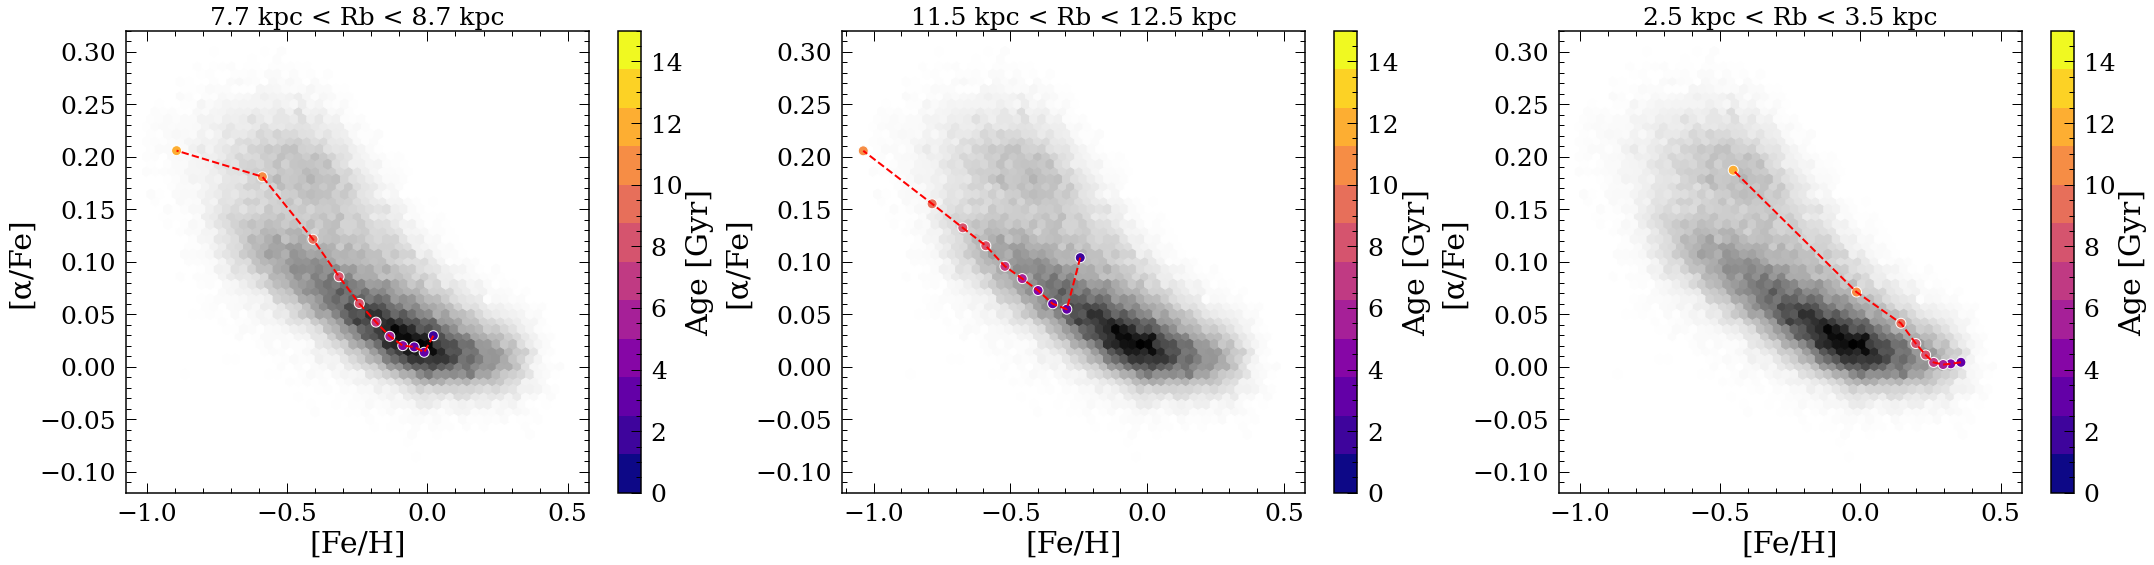

In [346]:
# without correction
agebin = np.linspace(0,12,13)

meanfeh = np.zeros(len(agebin)-1)
meanafe = np.zeros(len(agebin)-1)

sub_tryRb_sn = sub_rbir.loc[abs(sub_rbir['R']-8.2)<0.5].reset_index(drop=True)

plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb']-8.2)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('7.7 kpc < Rb < 8.7 kpc', fontsize=25)



plt.subplot(1,3,2)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb']-12)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('11.5 kpc < Rb < 12.5 kpc', fontsize=25)



plt.subplot(1,3,3)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb']-3)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('2.5 kpc < Rb < 3.5 kpc', fontsize=25)
plt.tight_layout()

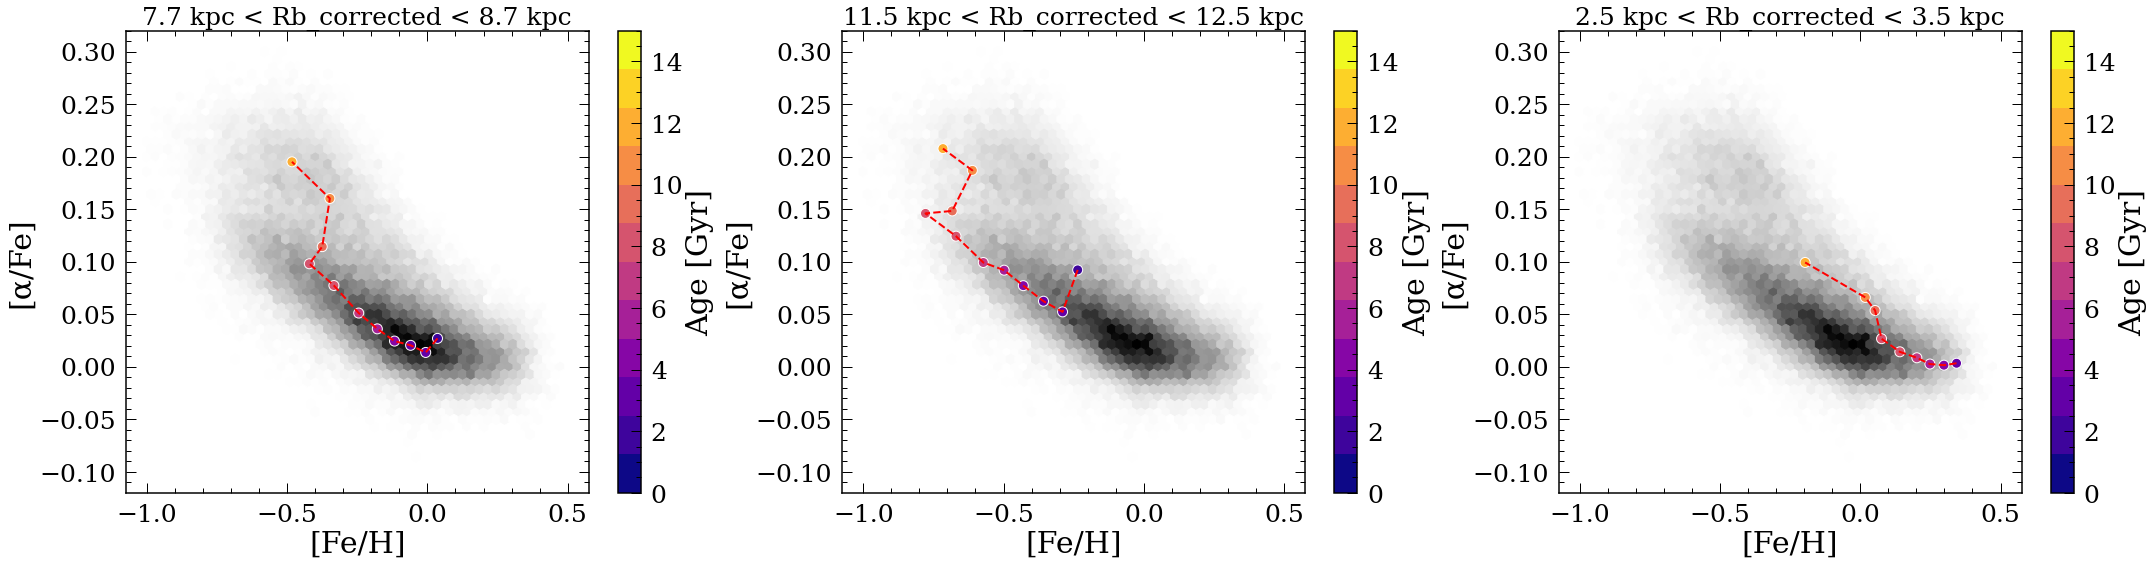

In [347]:
agebin = np.linspace(0,12,13)

meanfeh = np.zeros(len(agebin)-1)
meanafe = np.zeros(len(agebin)-1)

sub_tryRb_sn = sub_tryRb.loc[abs(sub_tryRb['R']-8.2)<0.5].reset_index(drop=True)

plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb_new']-8.2)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('7.7 kpc < Rb_corrected < 8.7 kpc', fontsize=25)



plt.subplot(1,3,2)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb_new']-12)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('11.5 kpc < Rb_corrected < 12.5 kpc', fontsize=25)



plt.subplot(1,3,3)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb_new']-3)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('2.5 kpc < Rb_corrected < 3.5 kpc', fontsize=25)
plt.tight_layout()

###  [$\alpha$/Fe] evolution for |R-10|<0.5

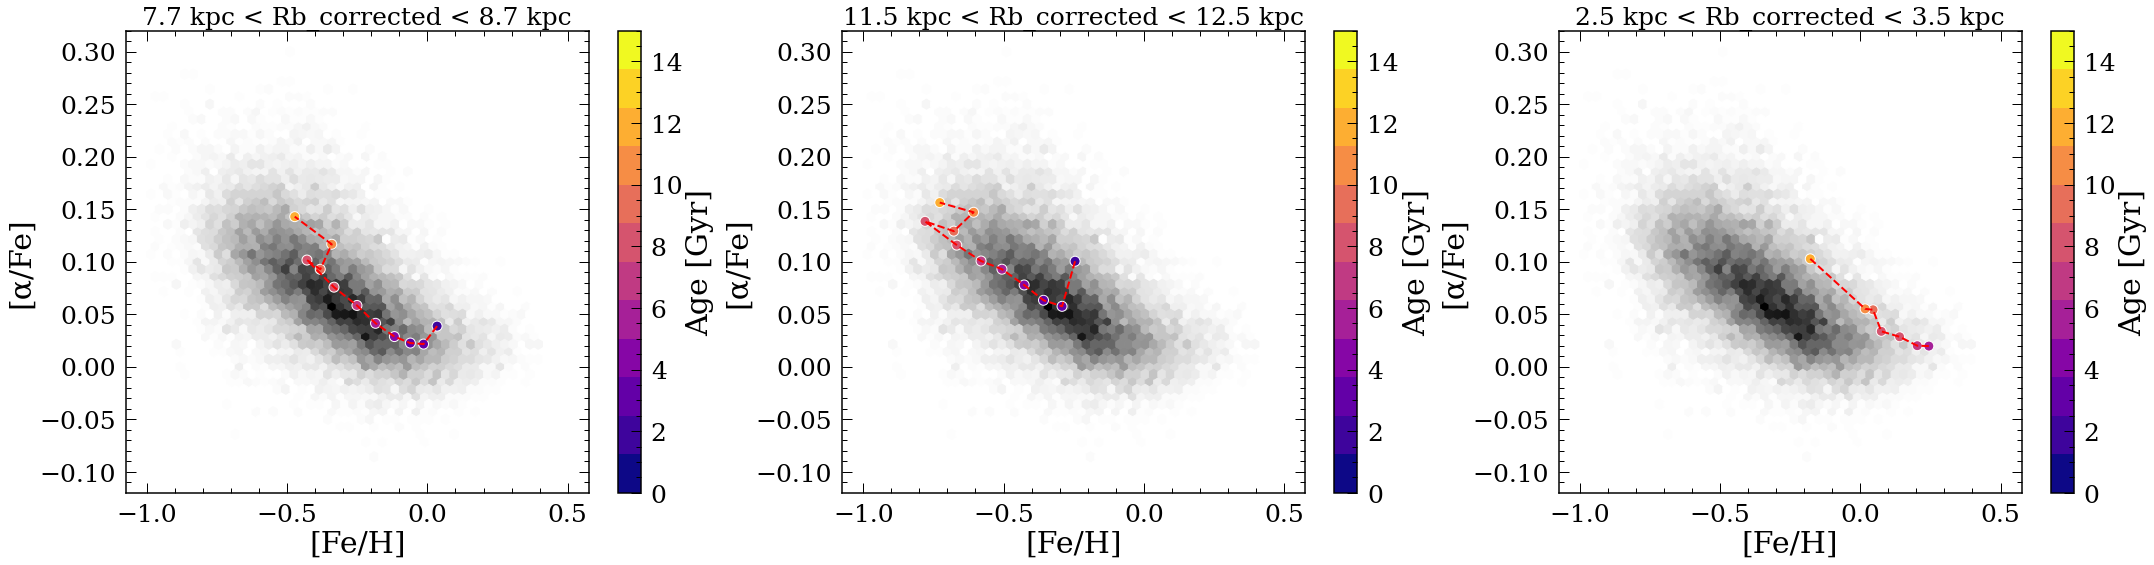

In [348]:
agebin = np.linspace(0,12,13)

meanfeh = np.zeros(len(agebin)-1)
meanafe = np.zeros(len(agebin)-1)

sub_tryRb_sn = sub_tryRb.loc[abs(sub_tryRb['R']-10)<0.5].reset_index(drop=True)

plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb_new']-8.2)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('7.7 kpc < Rb_corrected < 8.7 kpc', fontsize=25)



plt.subplot(1,3,2)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb_new']-12)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('11.5 kpc < Rb_corrected < 12.5 kpc', fontsize=25)



plt.subplot(1,3,3)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb_new']-3)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('2.5 kpc < Rb_corrected < 3.5 kpc', fontsize=25)
plt.tight_layout()

### check [α/Fe] scatter after correction

all stars 159769
with [Mg/Fe] 141972


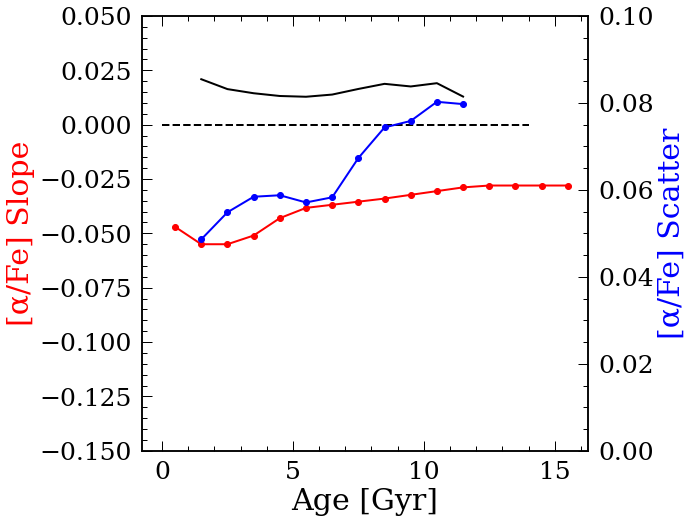

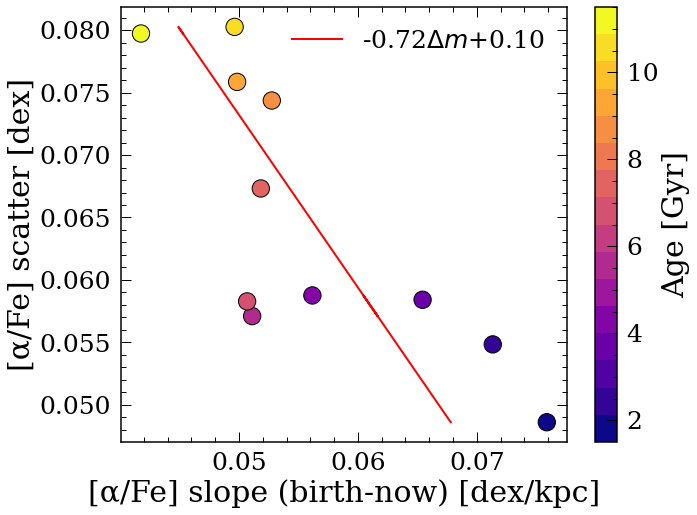

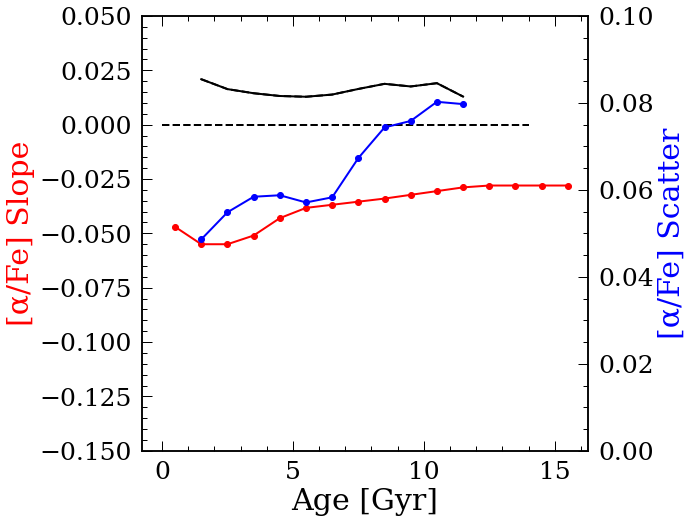

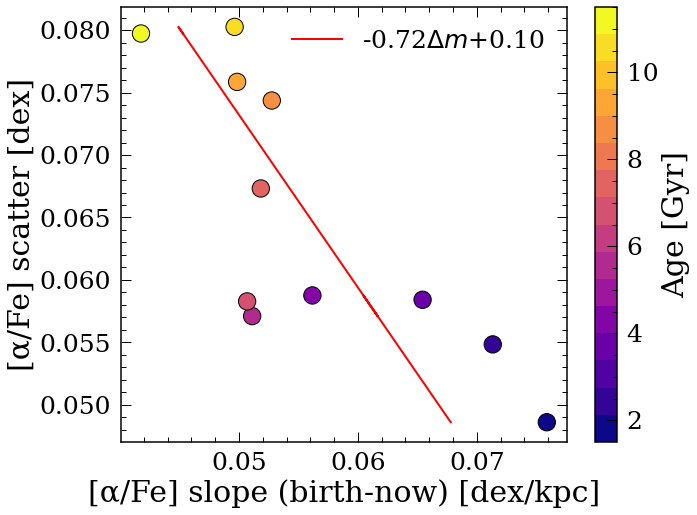

In [353]:

sub_check = sub_tryRb.loc[abs(sub_tryRb['Z'])<1].reset_index(drop=True)
sub_check = sub_check.loc[(sub_check['AGE_ERR']<np.diff(agebincalc)[0])]
sub_check = sub_check.loc[(sub_check['AGE']>1.5)].reset_index(drop=True)

#sub_check = sub_check.dropna(subset=['ALPHA_FE','ALPHA_FE_ERR'])
print('all stars', len(sub_check))
sub_check = pd.merge(sub_check, 
                     pd.read_csv('Xiang_elements.csv')[['MG_FE','MG_FE_ERR','SPECID']],
                    left_on='SPECID', right_on='SPECID',how='inner')
sub_check = sub_check.loc[abs(sub_check['MG_FE'])<100].dropna(subset=['MG_FE','MG_FE_ERR']).reset_index(drop=True)
print('with [Mg/Fe]', len(sub_check))

ages_afe, slopesafe_rbir, fehscatterafe_rbir = monoage_line(sub_check['MG_FE'].values, 
                                        sub_check['Rb_new'].values, 
                                        sub_check['AGE'].values,
                                        agebin=agebincalc,
                                        xlims=[0,15],
                                       feherr=sub_check['MG_FE_ERR'].values,
                                       plotlegend=False,pltfig=False)


agefit = 15

df = pd.read_csv('Xiang_selslope_afe.csv')
ages_afe, slopes_afe, fehscatter_afe = df['age'].values,df['slopes'].values,df['fehscatter'].values
slopesafe_err, fehscatterafe_err = df['slopes_err'], df['fehscatter_err']



age_and = [0.5, 1.5, 3, 5, 8.5, 12, 16]
slopes_and = [-0.047, -0.055, -0.055, -0.039, -0.034, -0.028, -0.028]

slopes_fit = interp1d(age_and, slopes_and)
slopes_afe = slopes_fit(ages_afe)
slopes_err = np.zeros(len(ages_afe))

offsetfac = 0.0
plt.figure(figsize=(8,8))
#plt.errorbar(ages_afe, slopes_afe, yerr=slopes_err, fmt='r-o')
plt.errorbar(ages_afe, slopes_afe, fmt='r-o')
plt.plot(ages_afe, slopesafe_rbir, 'k-',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('[α/Fe] Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.15, 0.05])

plt.twinx()
#plt.errorbar(ages_afe, fehscatter_afe, yerr=fehscatterafe_err, fmt='b-o')
plt.errorbar(ages_afe, fehscatter_afe, fmt='b-o')
plt.ylim([0.,0.1])
plt.ylabel('[α/Fe] Scatter', color='b',zorder=5)


df_afe = pd.DataFrame(np.array((ages_afe, slopes_afe, fehscatter_afe, slopesafe_rbir, fehscatterafe_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir'])


df_afe = df_afe.dropna(subset=['slopes','fehscatter']).reset_index(drop=True)

df_afe['slopes_rbir'] = df_afe['slopes_rbir']
m2 = (df_afe['age']<12)

plt.figure(figsize=(10,8))
plt.scatter(df_afe['slopes_rbir']-df_afe['slopes'], df_afe['fehscatter'], 
           c=df_afe['age'], s=300, edgecolor='k', 
            cmap=plt.get_cmap('plasma', len(df)))
p = fitpoints(df_afe['fehscatter'][m2], (df_afe['slopes_rbir']-df_afe['slopes'])[m2])
plt.xlabel('[α/Fe] slope (birth-now) [dex/kpc]')
plt.ylabel('[α/Fe] scatter [dex]')
plt.plot(p((df_afe['fehscatter']))[m2],
         (df_afe['fehscatter'])[m2], 'r-', 
         label="%.2f$Δm$+%.2f"%(p[1],p[0]))

slope_rbir_infer = np.zeros(len(df_afe))
slope_rbir_infer[~m2] = p((df_afe['fehscatter'][~m2]))+df_afe['slopes'][~m2]
slope_rbir_infer[m2] = df_afe['slopes_rbir'][m2]

df_afe['slope_rbir_infer'] = slope_rbir_infer

#print(df)

cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.legend()





plt.figure(figsize=(8,8))
plt.plot(ages_afe, slopes_afe, 'r-o')
plt.plot(ages_afe, slopesafe_rbir, 'k-',zorder=5)
plt.plot(df_afe['age'], df_afe['slope_rbir_infer'], 'k--',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('[α/Fe] Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.15, 0.05])

plt.twinx()
plt.plot(ages_afe, fehscatter_afe, 'b-o')
plt.ylim([0.,0.1])
plt.ylabel('[α/Fe] Scatter', color='b',zorder=5)




plt.figure(figsize=(10,8))
plt.scatter(df_afe['slope_rbir_infer']-df_afe['slopes'], df_afe['fehscatter'], 
           c=df_afe['age'], s=300, edgecolor='k', 
            cmap=plt.get_cmap('plasma', len(df)))
m2 = (df_afe['age']<agefit)

p = fitpoints(df_afe['fehscatter'][m2], (df_afe['slope_rbir_infer']-df_afe['slopes'])[m2])

plt.xlabel('[α/Fe] slope (birth-now) [dex/kpc]')
plt.ylabel('[α/Fe] scatter [dex]')
plt.plot(p((df_afe['fehscatter']))[m2],
         (df_afe['fehscatter'])[m2], 'r-', 
         label="%.2f$Δm$+%.2f"%(p[1],p[0]))

#df['slope_rbir_infer'] = p((df['fehscatter']))+df['slopes']

cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.legend()



In [282]:
"""from astropy import units as u
from astropy import uncertainty as unc
n_distr = unc.normal(sub['PARALLAX'].values*1/u.kpc, 
                     std=sub['PARALLAX_ERROR'].values*1/u.kpc, 
                     n_samples=1000)
dist = 1/n_distr
dist.pdf_median()
np.median(np.sqrt(dist.pdf_var()))
"""